# 📡 통신사 고객 이탈 예측 (Telco Churn Prediction)

## 1. 프로젝트 개요
본 프로젝트는 통신사 고객 데이터를 활용하여 **이탈(Churn) 가능성이 높은 고객을 사전에 식별**하고,  
이를 통해 **이탈 고객을 놓치지 않는 예측 모델을 구축**하는 것을 목표로 합니다.

이탈 고객은 전체 고객 중 소수에 해당하는 경우가 많아,  
단순 정확도(Accuracy) 중심의 접근만으로는 문제의 본질을 충분히 설명하기 어렵습니다.  
이에 따라 본 프로젝트에서는 **불균형 데이터 환경에서 어떤 기준으로 모델을 평가하고 선택해야 하는지**에 초점을 맞추었습니다.

## 2. 분석 목표
- 고객 특성 및 서비스 이용 패턴을 분석하여 이탈과 관련된 주요 요인 파악
- **이탈 고객을 최대한 놓치지 않는 것(Recall 중심)**을 1차 목표로 한 분류 모델 구축
- 단일 성능 지표가 아닌, **여러 평가 지표 간의 트레이드오프를 고려한 모델 비교**
- 모델 성능을 수치 나열이 아닌, **운영 관점에서 해석 가능한 기준으로 정리**

## 3. 데이터 설명
- **데이터 출처:** Kaggle Telco Churn Dataset  
- **관측 단위:** 고객 단위  
- **타깃 변수:** `Churn` (이탈 여부, Yes / No)

본 데이터는 수치형·범주형 변수가 혼합된 구조이며,  
이탈 고객 비율이 상대적으로 낮은 **불균형 데이터**라는 특성을 가지고 있습니다.  
이에 따라 전처리 방식과 모델 평가 전략을 함께 고려하여 분석을 진행했습니다.

## 4. 전체 분석 흐름
본 노트북은 아래와 같은 흐름으로 구성되어 있습니다.

1. 데이터 로드 및 기본 정제  
   - 컬럼명 정리 및 데이터 타입 변환  
   - 기초적인 결측치 처리  

2. 탐색적 데이터 분석(EDA)  
   - 변수 분포 및 타깃 변수 특성 확인  
   - 이탈 여부에 따른 주요 변수 비교  

3. 전처리 및 피처 엔지니어링  
   - 모델 학습을 위한 인코딩 및 스케일링  
   - 파생 변수 생성  

4. 분류 모델 학습 및 비교  

5. 성능 평가 및 결과 해석  


In [2]:
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# 재현성(난수 고정)
random.seed(SEED)
np.random.seed(SEED)

# 동일 경고 반복 줄임(필요 시 조정)
warnings.filterwarnings("once", category = FutureWarning)

# pandas 출력 옵션(EDA 편의)
pd.set_option("display.max_columns", None)

# 한글 폰트 설정: Windows(맑은 고딕) 기준, 타 환경에서는 기본 폰트로 진행
try:
    from matplotlib import font_manager

    font_path = r"C:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname = font_path).get_name()
    plt.rcParams["font.family"] = font_name
    plt.rcParams["axes.unicode_minus"] = False
except Exception:
    pass

# 실험 재현성 확보 및 환경별 병렬 처리 편차 최소화(CV/튜닝 시)
from threadpoolctl import threadpool_limits
threadpool_limits(limits = 1)


In [8]:
# 데이터 파일 load 
from pathlib import Path

# 경로 설정 (data 폴더 내의 CSV 파일)
DATA_PATH = Path("data") / "Telco-Customer-Churn.csv"

# 파일 존재 여부 확인
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"데이터 파일을 찾을 수 없습니다: {DATA_PATH}\n"
        f"현재 작업 디렉토리: {Path.cwd()}"
    )

# 데이터 불러오기
cust_df = pd.read_csv(DATA_PATH)

print("shape =", cust_df.shape)
cust_df.head()

shape = (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 컬럼 설명

| 컬럼명 | 설명 | 타입 | 값 / 범주 |
|------|------|------|-----------|
| customerID | 고객의 고유 식별자 | Categorical | 고유 ID |
| gender | 고객의 성별 | Categorical | Female, Male |
| SeniorCitizen | 고객이 65세 이상인지 여부 | Binary | 0: 미만, 1: 이상 |
| Partner | 파트너(배우자) 존재 여부 | Binary | Yes, No |
| Dependents | 부양가족 존재 여부 | Binary | Yes, No |
| tenure | 서비스 이용 기간(개월 수) | Numerical | 0 이상 정수 |
| PhoneService | 전화 서비스 이용 여부 | Binary | Yes, No |
| MultipleLines | 다회선 이용 여부 | Categorical | Yes, No, No phone service |
| InternetService | 인터넷 서비스 유형 | Categorical | DSL, Fiber optic, No |
| OnlineSecurity | 온라인 보안 서비스 이용 여부 | Categorical | Yes, No, No internet service |
| OnlineBackup | 온라인 백업 서비스 이용 여부 | Categorical | Yes, No, No internet service |
| DeviceProtection | 기기 보호 서비스 이용 여부 | Categorical | Yes, No, No internet service |
| TechSupport | 기술 지원 서비스 이용 여부 | Categorical | Yes, No, No internet service |
| StreamingTV | 스트리밍 TV 이용 여부 | Categorical | Yes, No, No internet service |
| StreamingMovies | 스트리밍 영화 이용 여부 | Categorical | Yes, No, No internet service |
| Contract | 계약 기간 | Categorical | Month-to-month, One year, Two year |
| PaperlessBilling | 전자 청구서 이용 여부 | Binary | Yes, No |
| PaymentMethod | 결제 방식 | Categorical | Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic) |
| MonthlyCharges | 월별 요금 | Numerical | 연속형 |
| TotalCharges | 누적 요금 | Numerical | 연속형 |
| Churn | 고객 이탈 여부 (타깃) | Binary | Yes: 이탈, No: 유지 |


## 데이터 기본 정제

In [11]:
# 컬럼 이름을 snake-case 방식으로 표준화
rename_map = {
    'customerID':        'customer_id',
    'SeniorCitizen':     'senior_citizen',
    'Partner':           'partner',
    'Dependents':        'dependents',
    'PhoneService':      'phone_service',
    'MultipleLines':     'multiple_lines',
    'InternetService':   'internet_service',
    'OnlineSecurity':    'online_security',
    'OnlineBackup':      'online_backup',
    'DeviceProtection':  'device_protection',
    'TechSupport':       'tech_support',
    'StreamingTV':       'streaming_tv',
    'StreamingMovies':   'streaming_movies',
    'Contract':          'contract',
    'PaperlessBilling':  'paperless_billing',
    'PaymentMethod':     'payment_method',
    'MonthlyCharges':    'monthly_charges',
    'TotalCharges':      'total_charges',
    'Churn':             'churn'
}

cust_df = cust_df.rename(columns = rename_map)

In [14]:
# 컬럼명 표준화 및 dtype 현황 재확인
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   int64  
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

In [15]:
# 전체 컬럼 기준 행 단위 중복 데이터 여부 확인
cust_df.duplicated().sum()

0

In [17]:
# 타깃 변수(churn) 분포 및 비율 확인
cust_df['churn'].value_counts(normalize=True)

churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

### 클래스 불균형 판단
이탈 고객 비율은 약 1:3 수준으로 확인되었으며, 극심한 불균형은 아니라고 판단.  
따라서 본 프로젝트에서는 우선 **모델 설정을 통해 소수 클래스에 가중치를 부여하는 방식**으로 접근하고,  
이후 성능 비교 결과에 따라 **샘플링 기반 기법 적용 여부를 추가로 검토**할 계획.

In [18]:
# senior_citizen 값 범위 확인 (이진 변수 여부 검증)
cust_df['senior_citizen'].unique()

array([0, 1], dtype=int64)

In [19]:
## 타깃 변수 및 주요 이진 변수 정제
# churn(No/Yes)을 0/1로 변환
# No -> 0 : 유지 고객
# Yes -> 1 : 이탈 고객
cust_df['churn'] = cust_df['churn'].map({'No': 0, 'Yes': 1})

# 2) 다른 범주형 변수와 일관된 EDA 및 인코딩을 위해 수치형 senior_citizen 변수를 문자열로 변환
# senior_citizen(0/1) 을 No/Yes로 변환
# 0 -> No : 65세 미만
# 1 -> Yes  : 65세 이상
cust_df["senior_citizen"] = cust_df["senior_citizen"].map({0: "No", 1: "Yes"})

In [20]:
# object로 되어있는 TotalCharges을 수치형으로 변환 (errors='coerce'로 변환 불가 시 NaN 처리) 
cust_df['total_charges'] = pd.to_numeric(cust_df['total_charges'], errors = 'coerce') 

In [21]:
cust_df.info()
# senior_citizen은 object, monthly_charges칼럼과 churn칼럼은 number타입으로 변경되었음을 재확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   gender             7043 non-null   object 
 2   senior_citizen     7043 non-null   object 
 3   partner            7043 non-null   object 
 4   dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   phone_service      7043 non-null   object 
 7   multiple_lines     7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  contract           7043 non-null   object 
 16  paperless_billing  7043 

In [22]:
# 결측치 재확인 (11개 결측치 발생)
cust_df.isnull().sum()  

customer_id           0
gender                0
senior_citizen        0
partner               0
dependents            0
tenure                0
phone_service         0
multiple_lines        0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
contract              0
paperless_billing     0
payment_method        0
monthly_charges       0
total_charges        11
churn                 0
dtype: int64

## 결측치 처리

In [23]:
# 1) 결측치 원인 파악. 결측치가 발생한 행들의 tenure(가입기간)확인  
cust_nan = cust_df.loc[cust_df['total_charges'].isna(), ['tenure','monthly_charges', 'total_charges']]
display(cust_nan)


# 2) 신규 가입자(tenure=0)는 아직 누적 청구 금액이 없으므로, 결측값을 0으로 대치
cust_df['total_charges'] = cust_df['total_charges'].fillna(0)

,tenure,monthly_charges,total_charges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


In [24]:
cust_df.loc[cust_df['tenure'] == 0]

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,0
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,0
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,0
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,0
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,0
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,0
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,0
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,0
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,0
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,0


In [25]:
# 결측치 여부 재확인
cust_df.isnull().sum()

customer_id          0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

## 수치형 변수들에 대한 기초통계량 확인

In [26]:
# 수치형 칼럼들의 기초 통계량 확인
# 향후 수치형 변수들과 이탈 여부의 분포를 비교
cust_df[['tenure', 'monthly_charges', 'total_charges']].describe()

,tenure,monthly_charges,total_charges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


## 이상치 탐색

### total_charge 이상치, 왜도 탐색

In [27]:
# 1) IQR 계산
q1 = cust_df['total_charges'].quantile(0.25)
q3 = cust_df['total_charges'].quantile(0.75)
iqr = q3 - q1

# 2) 이상치 경계 설정 (1.5*IQR)
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# 3) 이상치 비율 계산
outliers = cust_df[(cust_df['total_charges'] < lower) | (cust_df['total_charges'] > upper)]
outlier_ratio = len(outliers) / len(cust_df) * 100

total_charge_skew = cust_df['total_charges'].skew()
print(f'total_charges 왜도: {total_charge_skew:.2f}')

print('IQR:', iqr.round(1))
print(f'lower : {lower:.3f}, upper : {upper:.3f}')
print(f"총 {len(outliers)}건 ({outlier_ratio:.2f}%) 이상치 존재.")

total_charges 왜도: 0.96
IQR: 3388.0
lower : -4683.525, upper : 8868.675
총 0건 (0.00%) 이상치 존재.


### monthly_charges 이상치, 왜도 탐색

In [28]:
# 1) IQR 계산
q1 = cust_df['monthly_charges'].quantile(0.25)
q3 = cust_df['monthly_charges'].quantile(0.75)
iqr = q3 - q1

# 2) 이상치 경계 설정 (1.5*IQR)
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# 3) 이상치 비율 계산
outliers = cust_df[(cust_df['monthly_charges'] < lower) | (cust_df['monthly_charges'] > upper)]
outlier_ratio = len(outliers) / len(cust_df) * 100

monthly_charges_skew = cust_df['monthly_charges'].skew()
print(f'monthly_charges 왜도: {monthly_charges_skew:.2f}')

print('IQR:', iqr.round(1))
print(f'lower : {lower:.3f}, upper : {upper:.3f}')
print(f"총 {len(outliers)}건 ({outlier_ratio:.2f}%) 이상치 존재.")

monthly_charges 왜도: -0.22
IQR: 54.4
lower : -46.025, upper : 171.375
총 0건 (0.00%) 이상치 존재.


# 탐색적 데이터 분석 (EDA) 수행

C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\3579041818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'churn', data = cust_df, palette = 'pastel')


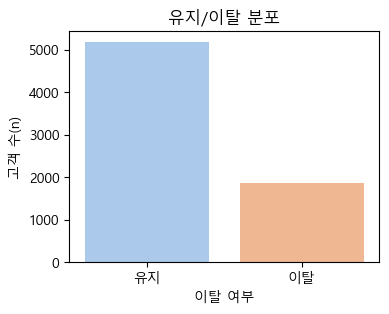

In [29]:
# 이탈 여부 churn 칼럼의 분포 확인 
plt.figure(figsize = (4,3))
sns.countplot(x = 'churn', data = cust_df, palette = 'pastel')
plt.xticks([0, 1], ['유지', '이탈'])
plt.xlabel('이탈 여부')
plt.ylabel('고객 수(n)')
plt.title('유지/이탈 분포')
plt.show()

# 결과 해석 : 클래스 불균형이 존재하기 때문에 Accuracy값은 높아질 수 있고 Precision/Recall이 낮게 나타날 수 있음. 
# Precision/Recall 지표를 중점적으로 살펴야 함

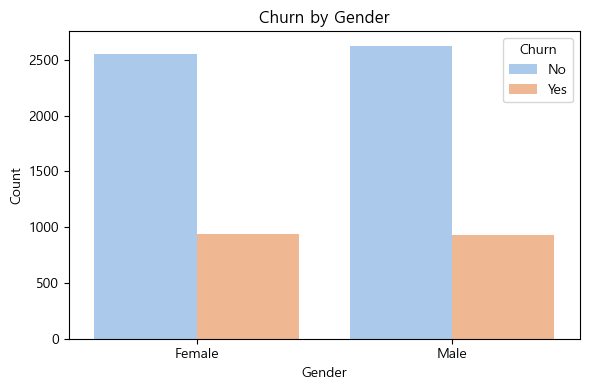

In [30]:
# 성별에 따른 이탈 여부 분포
plt.figure(figsize = (6,4))
sns.countplot(x = 'gender', hue = 'churn', data = cust_df, palette = 'pastel')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Churn by Gender')
plt.legend(title = 'Churn', labels = ['No', 'Yes'])
plt.tight_layout()
plt.show()

In [31]:
from scipy.stats import chi2_contingency

tab = pd.crosstab(cust_df['gender'], cust_df['churn'])
chi2, p, dof, exp = chi2_contingency(tab)
n = tab.values.sum()
phi2 = chi2/n
r, k = tab.shape
cramers_v = np.sqrt(phi2 / min(k-1, r-1))

print("이탈률\n", (tab.T / tab.sum(1)).T)   # 각 성별의 churn 비율
print(f"chi2 p={p:.4g}, Cramér's V={cramers_v:.3f}")

# Cramer V : 연관 효과 크기, 0~1, 0.008 : 실질적 영향 없음. 

이탈률
 churn          0         1
gender                    
Female  0.730791  0.269209
Male    0.738397  0.261603
chi2 p=0.4866, Cramér's V=0.008


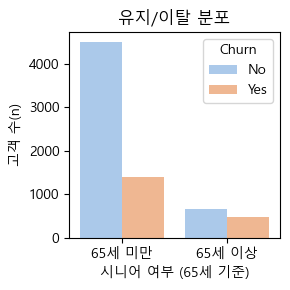

In [32]:
# 65세 나이를 기준으로 이탈 여부 분포 
plt.figure(figsize=(3,3))
sns.countplot(x = 'senior_citizen', hue = 'churn', data = cust_df, palette = 'pastel')
plt.xticks([0, 1], ['65세 미만', '65세 이상'])
plt.xlabel('시니어 여부 (65세 기준)')
plt.ylabel('고객 수(n)')
plt.title('유지/이탈 분포')
plt.legend(title = 'Churn', labels = ['No', 'Yes'])
plt.tight_layout()
plt.show()

<Figure size 300x300 with 0 Axes>

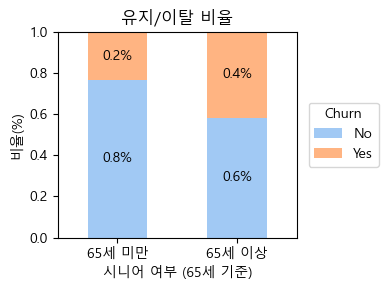

In [56]:
# 65세 기준으로 이탈 여부 비율 확인
table = pd.crosstab(cust_df['senior_citizen'], cust_df['churn'], normalize = 'index')
pastel_colors = sns.color_palette("pastel", 2)

plt.figure(figsize = (3,3))
ax = table.plot(
    kind = 'bar',
    stacked = True,
    color = pastel_colors,
    figsize = (4,3)           
)

# 축 레이블, 타이틀 설정
ax.set_xticklabels(['65세 미만','65세 이상'], rotation = 0)
ax.set_xlabel('시니어 여부 (65세 기준)')
ax.set_ylabel('비율(%)')
ax.set_ylim(0,1)
ax.set_title('유지/이탈 비율')

# 비율 레이블(%) 추가
for container in ax.containers:
    ax.bar_label(container, fmt = '%.1f%%', label_type = 'center')

# 범례를 플롯 오른쪽 밖으로 이동
ax.legend(
    title = 'Churn',
    labels = ['No','Yes'],
    loc = 'center left',
    bbox_to_anchor = (1.02, 0.5)  # 플롯 밖 오른쪽 중앙에 고정
)

plt.tight_layout()
plt.show()

In [24]:
# senior_citizen 여부에 따른 이탈 비율 차이가 우연히 발생한 것인지 검정하기 위해 카이제곱 독립성 검정을 수행. 
# 가설 설정
# (귀무가설): senior_citizen과 이탈 여부는 통계적으로 독립적이다.
# (대립가설): senior_citizen과 이탈 여부는 통계적으로 독립적이지 않다 (연관성이 있다).

from scipy.stats import chi2_contingency

# 교차표 생성
table = pd.crosstab(cust_df['senior_citizen'], cust_df['churn'])
print("Observed table:\n", table, "\n")

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(table)

# 기대빈도 행렬 출력
expected_df = pd.DataFrame(expected, 
                           index = table.index, 
                           columns = table.columns)
print("Expected table:\n", expected_df, "\n")

# p-value 출력
print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")

# 검정 결과 : p-value가 0.001 미만으로 나타나 귀무가설을 기각하여 두 그룹 간 이탈 비율 차이가 통계적으로 유의미함.

Observed table:
 churn              0     1
senior_citizen            
No              4508  1393
Yes              666   476 

Expected table:
 churn                     0            1
senior_citizen                          
No              4335.052392  1565.947608
Yes              838.947608   303.052392 

Chi2 = 159.43, p-value = 0.0000, dof = 1


C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\1434827401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\1434827401.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['65세 미만', '65세 이상'])
C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\1434827401.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\1434827401.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['65세 미만', '65세 이상'])


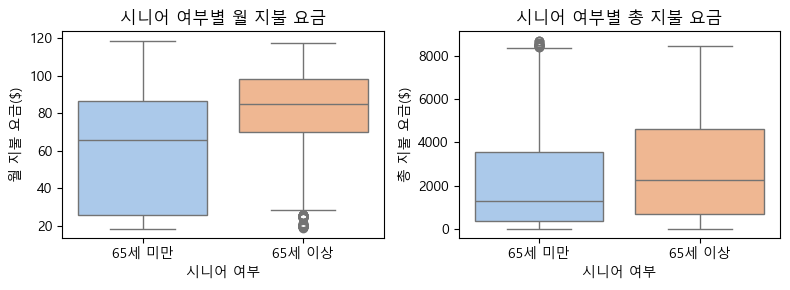

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# senior_citizen(65세 이상 여부)별 Monthly Charges 분포 비교
sns.boxplot(
    x = 'senior_citizen',
    y = 'monthly_charges',
    data = cust_df,
    palette = 'pastel',
    ax = axes[0]
)
axes[0].set_xticklabels(['65세 미만', '65세 이상'])
axes[0].set_xlabel('시니어 여부')
axes[0].set_ylabel('월 지불 요금($)')
axes[0].set_title('시니어 여부별 월 지불 요금')

# senior_citizen(65세 이상 여부)별 Total Charges 분포 비교
sns.boxplot(
    x = 'senior_citizen',
    y = 'total_charges',
    data = cust_df,
    palette = 'pastel',
    ax = axes[1]
)
axes[1].set_xticklabels(['65세 미만', '65세 이상'])
axes[1].set_xlabel('시니어 여부')
axes[1].set_ylabel('총 지불 요금($)')
axes[1].set_title('시니어 여부별 총 지불 요금')

plt.tight_layout()
plt.show()

# 결과 : 65세 이상인 고객들은 상대적으로 높은 월 요금을 지불하고 있음. 
# 65세 이하 고객들은 다양한 월 요금제를 사용하고 있음. 

In [34]:
median_over65 = cust_df.loc[cust_df['senior_citizen'] == 'Yes', 'monthly_charges'].median()
median_under65 = cust_df.loc[cust_df['senior_citizen'] == 'No', 'monthly_charges'].median()

print('over65_median :', median_over65, 'under65_median :', median_under65)

over65_median : 84.85 under65_median : 65.8


## 현재까지의 결과
- 65세 이상 고객의 이탈 비율이 65세 미만 대비 높게 관찰됨.
- 65세 이상 고객은 월별 요금이 상대적으로 높은 분포를 보임.
- 반면, 65세 미만 고객은 저가·중가·고가 요금제를 폭넓게 사용함.
- 이에 따라 시니어 고객의 **고요금 플랜 사용 요인(서비스 구성/계약 유형 등)**을 추가로 확인할 필요가 있음.


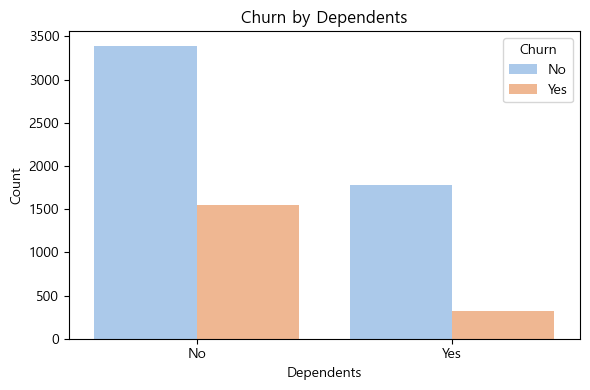

In [35]:
# 부양가족 존재 여부 별 이탈여부
plt.figure(figsize = (6,4))
sns.countplot(
    x = 'dependents',
    hue = 'churn',
    data = cust_df,
    order = ['No','Yes'],
    palette = sns.color_palette("pastel")[0:2]
)
plt.xlabel('Dependents')
plt.ylabel('Count')
plt.title('Churn by Dependents')
plt.legend(title = 'Churn', labels = ['No', 'Yes'])
plt.tight_layout()
plt.show()

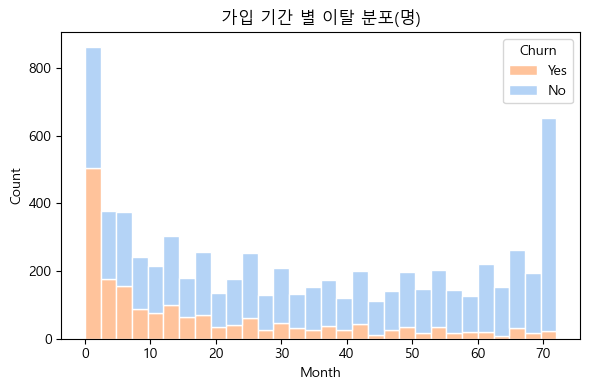

In [36]:
# 가입기간별 이탈분포 
palette = sns.color_palette("pastel")[0:2]

plt.figure(figsize=(6,4))
ax = sns.histplot(
    data = cust_df,
    x = 'tenure',
    hue = 'churn',
    hue_order = [0, 1],               
    palette = palette,  #[No, Yes] 순서
    multiple = 'stack',
    bins = 30,
    edgecolor = 'w',
    alpha = 0.8
)
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('가입 기간 별 이탈 분포(명)')
plt.legend(title = 'Churn', labels = ['Yes', 'No'])
plt.tight_layout()
plt.show()

# 결과 : 장기 고객들에 비해 1년 이하 유지 고객에게서 상대적으로 높은 이탈률을 보이고 있으며, 특히 신규 가입 고객들에게서 높은 이탈률이 나타남.
# 신규 고객군을 별도 세그먼트로 관리. 

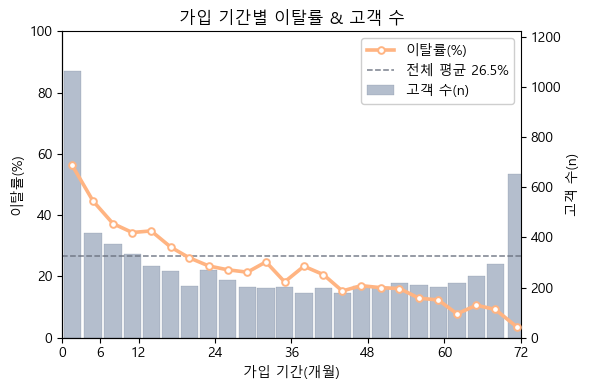

In [37]:
palette   = sns.color_palette("pastel")[0:2]
yes_color = palette[1]

# 1) churn을 0/1로 정규화
churn_map = {'Yes':1, 'No':0, 1:1, 0:0, True:1, False:0}
is_churn = cust_df['churn'].map(churn_map)
if is_churn.isna().any():
    is_churn = cust_df['churn'].astype(str).str.lower().isin(['yes','y','1','true']).astype(int)

# 2) 30개 bin으로 나누고 bin별 이탈률/표본수 계산
bins = np.linspace(cust_df['tenure'].min(), cust_df['tenure'].max(), 25)
dfb = pd.DataFrame({'tenure': cust_df['tenure'], 'is_churn': is_churn})
dfb['bin'] = pd.cut(dfb['tenure'], bins = bins, include_lowest = True)

grp        = dfb.groupby('bin', observed=True)
n          = grp.size()                          # 표본 수
churn_rate = grp['is_churn'].mean() * 100        # 이탈률(%)
mid        = grp['tenure'].mean()                # 각 bin의 중앙값(x좌표)
overall    = is_churn.mean() * 100               # 전체 평균 이탈률

# --- 플롯 ---
fig, ax1 = plt.subplots(figsize = (6, 4))
ax2 = ax1.twinx()

# (a) n 보조 바 — 조금 더 진하고 선명하게
bin_w = (bins[1] - bins[0]) * 0.9
ax2.bar(mid, n, width=bin_w,
        color = '#94A3B8', alpha = 0.70,      # 밝은 회회색 + 약간 진한 투명도
        edgecolor = '#64748B', linewidth = 0.2,
        label = '고객 수(n)', zorder = 1)
ax2.set_ylabel('고객 수(n)')
ax2.set_ylim(0, n.max() * 1.15)
ax2.grid(False)

# (b) 이탈률 라인 — 대비 강화(굵기↑, 흰색 마커면, 최상단 zorder)
ax1.plot(mid, churn_rate,
         color = yes_color, linewidth = 2.6, marker = 'o', markersize = 4.8,
         markerfacecolor = 'white', 
         markeredgecolor = yes_color, markeredgewidth = 1.4,
         label = '이탈률(%)', zorder = 3)

# (c) 전체 평균 이탈률 기준선
ax1.axhline(overall, ls = '--', lw = 1.1, color = '#6B7280', alpha = 0.9,
            label = f'전체 평균 {overall:.1f}%')

# 축/레이블/범례
ax1.set_xlabel('가입 기간(개월)')
ax1.set_ylabel('이탈률(%)')
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 20))
ax1.set_xlim(bins[0], bins[-1])
ax1.set_xticks([0, 6, 12, 24, 36, 48, 60, 72])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc='upper right', frameon=True, framealpha=0.95)

# 겹침/가독성 스타일
ax1.grid(False); ax2.grid(False)
ax1.set_zorder(2)           # 라인이 바 위에 오도록
ax1.patch.set_alpha(0)      # 라인 아래 배경 투명화(바 색과 겹침 최소화)
for s in ['top','right']:
    ax1.spines[s].set_visible(False)

plt.title('가입 기간별 이탈률 & 고객 수')
plt.tight_layout()
plt.show()

In [38]:
# EDA 해석용 파생 변수 (모델 입력에는 사용하지 않음)
bins = [0, 5, 12, 24, 48, 72]
labels = ['0–5','6–12','13–24','25–48','49–72']
cust_df['tenure_group'] = pd.cut(cust_df['tenure'], bins = bins, labels = labels)

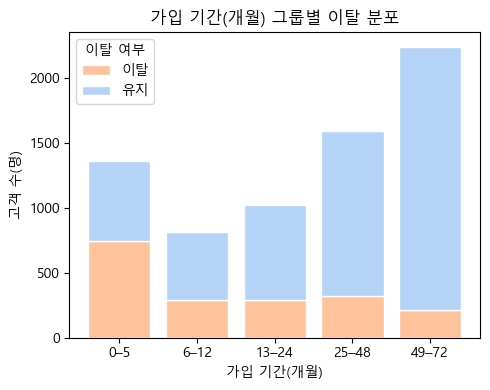

In [39]:
plt.figure(figsize=(5,4))
sns.histplot(
    data = cust_df,
    x = 'tenure_group',
    hue = 'churn',
    hue_order = [0, 1],
    palette = palette,
    multiple = 'stack',
    discrete = True,      # 범주형 데이터로 처리
    shrink = 0.8,         # 바 폭을 80%로 줄임
    edgecolor = 'w',
    alpha = 0.8
)
plt.xlabel('가입 기간(개월)')
plt.ylabel('고객 수(명)')
plt.title('가입 기간(개월) 그룹별 이탈 분포')
plt.legend(title = '이탈 여부', labels = ['이탈', '유지'])
plt.tight_layout()
plt.show()

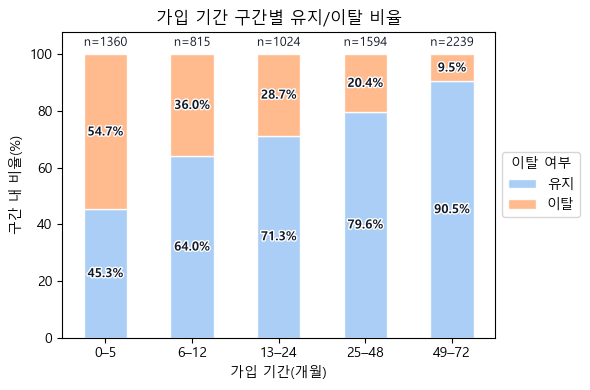

In [40]:
import matplotlib.patheffects as pe
palette = sns.color_palette("pastel")[0:2]

# 1) 교차표
ct = pd.crosstab(cust_df['tenure_group'], cust_df['churn'])

# 2) 컬럼(이탈 여부) 순서 및 범례 라벨 결정
if {'No','Yes'}.issubset(ct.columns):
    churn_cols = ['No', 'Yes']
    legend_labels = ['유지', '이탈']
elif {0,1}.issubset(set(ct.columns)):
    churn_cols = [0, 1]
    legend_labels = ['유지', '이탈']
else:
    churn_cols = list(ct.columns)
    legend_labels = [str(c) for c in churn_cols]

# 3) 비율 변환 (%)
pct = ct[churn_cols].div(ct.sum(axis = 1), axis = 0) * 100

# 5) 플롯
fig, ax = plt.subplots(figsize = (6, 4))
pct.plot(kind = 'bar', stacked = True, color = palette, edgecolor = 'white', alpha = 0.9, ax = ax)

# x축 레이블 정면(회전 0°)
plt.xticks(rotation = 0, ha = 'center')

# n(표본 수) 표기를 위해 여유 공간 확보
ax.set_ylim(0, 108)

# 6) 막대 내부 퍼센트 라벨 (아주 작은 구간은 생략해 가독성 유지)
for i, (_, row) in enumerate(pct.iterrows()):
    cum = 0
    for val in row:
        if val >= 6:  # 6% 미만 구간은 라벨 생략
            ax.text(i, cum + val/2, f'{val:.1f}%', ha = 'center', va = 'center',
                    color = '#111827', fontsize = 9, fontweight = 'semibold',
                path_effects = [pe.withStroke(linewidth = 2, foreground = 'white')])
        cum += val

# 7) 각 그룹의 n(표본 수) - 막대 위에 은은하게 표시
n_per_group = ct.sum(axis = 1)
for i, grp in enumerate(pct.index):
    ax.text(i, 102, f'n={int(n_per_group.loc[grp])}',
            ha = 'center', va = 'bottom', fontsize = 9, color = '#111827', path_effects = [pe.withStroke(linewidth = 2.2, foreground = 'white')])

# 8) 레이블/제목/범례
ax.set_xlabel('가입 기간(개월)')
ax.set_ylabel('구간 내 비율(%)')
ax.set_title('가입 기간 구간별 유지/이탈 비율')
ax.legend(title = '이탈 여부', labels = legend_labels, loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.tight_layout()
plt.show()

### 가입 초기 고객 이탈의 원인 탐색: 계약 유형 관점

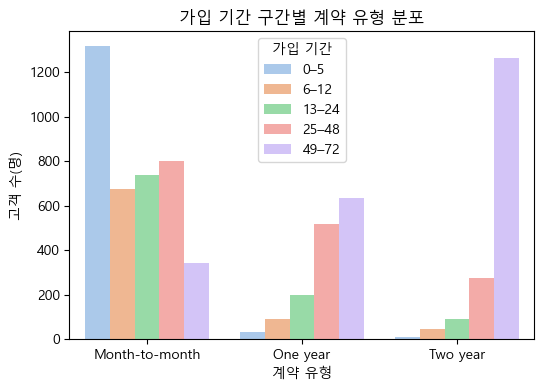

In [42]:
# 가입기간 그룹별 계약유형 분포
plt.figure(figsize = (6,4))

sns.countplot(x = 'contract', hue = 'tenure_group', data = cust_df, palette = 'pastel')
plt.xlabel('계약 유형')
plt.ylabel('고객 수(명)')
plt.title('가입 기간 구간별 계약 유형 분포')
plt.legend(title = '가입 기간')

# 결과 해석:
# 가입 기간이 가장 짧은 그룹(0–5개월)은 Month-to-month 계약 비중이 압도적으로 높게 나타남.
# Month-to-month 계약은 의무 사용 기간이나 해지 비용이 없어,
# 초기 불만이나 기대 불일치 발생 시 이탈로 이어질 가능성이 높다고 해석할 수 있음.
# 따라서 초기 가입자, 특히 Month-to-month 고객을 대상으로 한
# 초기 유지 프로모션 전략이 필요함.


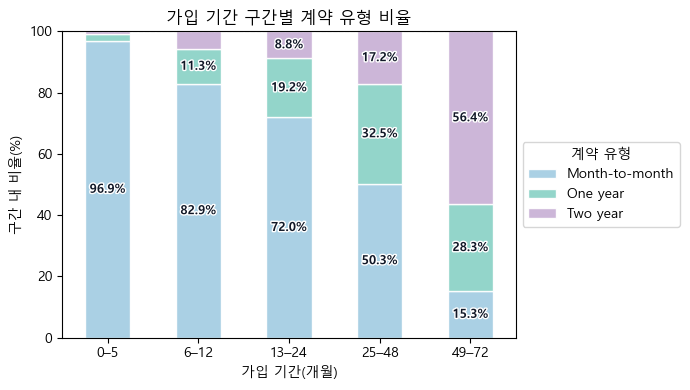

In [43]:
import matplotlib.patheffects as pe

# ===== 1) 순서 정의 (데이터 라벨에 맞춰 en-dash/hyphen 모두 대응) =====
# 현재 라벨에 '–'(en-dash)가 있으면 그 버전으로, 아니면 '-' 사용
def tenure_order_from(index_vals):
    if any('–' in str(x) for x in index_vals):
        return ['0–5','6–12','13–24','25–48','49–72']
    else:
        return ['0-5','6-12','13-24','25-48','49-72']

CONTRACT_ORDER = ['Month-to-month', 'One year', 'Two year']

# ===== 2) 교차표 → 그룹 내(행) 100% 비율 =====
ct  = pd.crosstab(cust_df['tenure_group'], cust_df['contract'])
# 순서 정리
TENURE_ORDER = tenure_order_from(ct.index)
ct  = ct.reindex(TENURE_ORDER)                # 존재하는 항목만 순서대로 정렬
ct  = ct[[c for c in CONTRACT_ORDER if c in ct.columns]]

pct = ct.div(ct.sum(axis = 1), axis = 0) * 100    # 각 가입기간 그룹 내 비율(%)

# ===== 3) 색상(계약유형 고정) =====
palette = {
    'Month-to-month': '#A6CEE3',  # 파스텔 블루
    'One year'      : '#8DD3C7',  # 민트
    'Two year'      : '#CAB2D6'   # 라일락
}
colors = [palette[c] for c in pct.columns]

# ===== 4) 플롯 (100% 스택) =====
fig, ax = plt.subplots(figsize = (7, 4))
pct.plot(kind = 'bar', stacked = True, color = colors, edgecolor = 'white', alpha = 0.95, ax = ax)

# 축/제목
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = 'center')
ax.set_ylim(0, 100)                          # 꼭대기 = 100%
ax.set_yticks(range(0, 101, 20))
ax.axhline(100, lw = 0.8, ls = '--', color = 'gray', alpha = 0.6)  # 100% 기준선
ax.set_xlabel('가입 기간(개월)')
ax.set_ylabel('구간 내 비율(%)')
ax.set_title('가입 기간 구간별 계약 유형 비율')

# 범례
ax.legend(title = '계약 유형', loc = 'center left', bbox_to_anchor = (1, 0.5))

# ===== 5) 퍼센트 라벨 (작은 구간은 생략해 지저분함 방지) =====
for i, (_, row) in enumerate(pct.iterrows()):
    cum = 0
    for c in pct.columns:
        val = row[c]
        if val >= 7:  # 7% 미만은 라벨 생략
            ax.text(
                i, cum + val/2, f'{val:.1f}%',
                ha = 'center', va = 'center',
                color = '#111827', fontsize = 9, fontweight = 'semibold',
                path_effects = [pe.withStroke(linewidth = 2, foreground = 'white')]
            )
        cum += val

plt.tight_layout()
plt.show()

### 인터넷 서비스별 유지/이탈 분포, 비율 확인

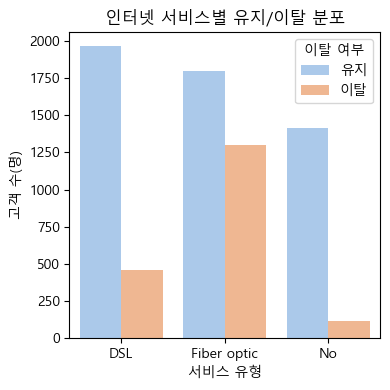

In [44]:
# 인터넷 서비스 유형별 이탈 분포 확인
palette = sns.color_palette("pastel")[0:2]

plt.figure(figsize = (4,4))
sns.countplot(
    x = 'internet_service',
    hue = 'churn',
    data = cust_df,
    palette = palette
)
plt.xlabel('서비스 유형')
plt.ylabel('고객 수(명)')
plt.title('인터넷 서비스별 유지/이탈 분포')
plt.legend(title = '이탈 여부', labels = ['유지', '이탈'])
plt.tight_layout()
plt.show()

# 결과 : Fiber optic 인터넷 서비스를 가입한 고객에서 높은 이탈률을 보임. 

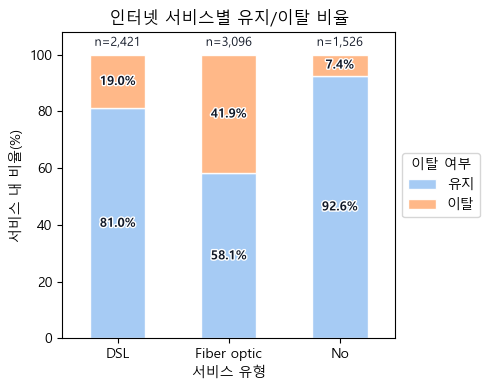

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

palette = sns.color_palette("pastel")[0:2]   # [파랑, 주황]

# 서비스 내 비율(%) 계산
ct  = pd.crosstab(cust_df['internet_service'], cust_df['churn'])
cols = ['No','Yes'] if {'No','Yes'}.issubset(ct.columns) else [0,1]
pct = ct[cols].div(ct.sum(axis=1), axis=0) * 100

# 100% 스택 바
fig, ax = plt.subplots(figsize=(5,4))
pct.plot(kind = 'bar', stacked = True,
         color = palette,
         edgecolor = 'white', alpha = 0.95, ax = ax)

# x축 레이블 정면
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, ha = 'center')

ax.set_xlabel('서비스 유형')
ax.set_ylabel('서비스 내 비율(%)')
ax.set_title('인터넷 서비스별 유지/이탈 비율')

# ▶ 여유 공간 확보(상단 머리 공간) + 눈금은 0~100만 표기
ax.set_ylim(0, 108)
ax.set_yticks(range(0, 101, 20))
ax.legend(title = '이탈 여부', labels = ['유지', '이탈'],
          loc = 'center left', bbox_to_anchor = (1,0.5))

# 퍼센트 라벨(작은 구간은 생략)
for i, (_, row) in enumerate(pct[cols].iterrows()):
    cum = 0
    for c in cols:
        v = row[c]
        if v >= 7:
            ax.text(i, cum + v/2, f'{v:.1f}%', ha = 'center', va = 'center',
                    color = '#111827', fontsize = 9, fontweight = 'semibold',
                    path_effects = [pe.withStroke(linewidth = 2, foreground = 'white')])
        cum += v

# ▶ n 레이블: 항상 상단에서 일정 간격(예: 4포인트) 아래에 표기
y_bottom, y_top = ax.get_ylim()        # (0, 108)
n_y = y_top - 6                        # = 104 위치
n_per_service = ct.sum(axis=1)

for i, svc in enumerate(pct.index):
    ax.text(i, n_y, f'n={int(n_per_service.loc[svc]):,}',
            ha = 'center', va = 'bottom',
            fontsize = 9, color = '#111827',
            path_effects = [pe.withStroke(linewidth = 2.2, foreground = 'white')],
            zorder = 5)
plt.tight_layout()
plt.show()

### 인터넷 서비스와 월 요금 관계

C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\644093729.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\644093729.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\leeno\AppData\Local\Temp\ipykernel_10276\644093729.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(order, rotation=0, ha='center')


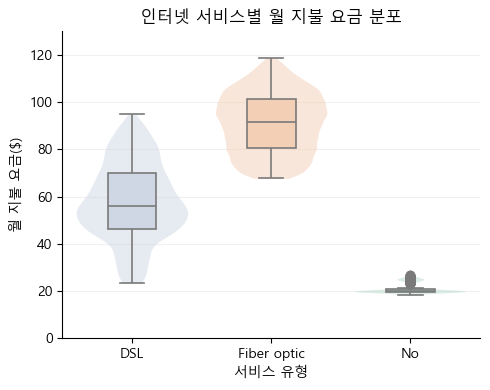

In [47]:
from matplotlib.ticker import FuncFormatter

order = ['DSL', 'Fiber optic', 'No']
pal   = sns.color_palette("Pastel2")
cmap  = {'DSL': pal[2], 'Fiber optic': pal[1], 'No': pal[0]}

plt.figure(figsize=(5,4))
# 1) 바이올린 플롯
ax = sns.violinplot(
    data = cust_df, x = 'internet_service', y = 'monthly_charges',
    order = order, palette = cmap, cut = 0, inner = None, linewidth = 0, alpha = 0.5
)
# 2) 박스 플롯
sns.boxplot(
    data = cust_df, x = 'internet_service', y = 'monthly_charges',
    order = order, palette = cmap, width = 0.35, linewidth = 1.2, showfliers = True, ax = ax
)

ax.set_title('인터넷 서비스별 월 지불 요금 분포')
ax.set_xlabel('서비스 유형'); ax.set_ylabel('월 지불 요금($)')
ax.set_xticklabels(order, rotation = 0, ha = 'center')
ax.yaxis.grid(True, alpha=0.18); ax.set_axisbelow(True)
ax.set_ylim(0, 130)
for s in ['top','right']: ax.spines[s].set_visible(False)
plt.tight_layout()
plt.show();

In [48]:
# 통계적 검정으로 인터넷 서비스 유형, 이탈 여부 간의 유의미성 확인
# 귀무가설 : 인터넷 서비스 유형과 이탈 여부는 독립적. (관련 없음)
# 대립가설 : 두 변수는 독립적이지 않음. (관련 있음)
table = pd.crosstab(cust_df['internet_service'], cust_df['churn'])

chi2, p, _, exp = chi2_contingency(table)
print("p-value =", p)

# p-value < 0.05 이므로 귀무가설을 기각.
# 인터넷 서비스 유형에 따라 이탈률 차이가 통계적으로 유의미.
# 연관성은 있으나 인과성은 X

p-value = 9.571788222840544e-160


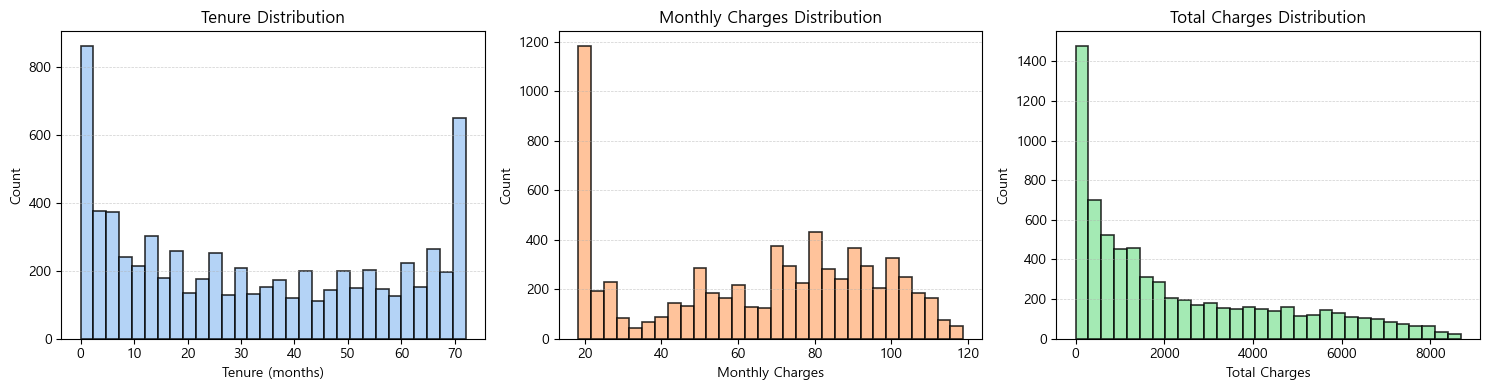

In [49]:
# 가입 개월 수, 월 지불 금액, 총 지불 금액 histogram
colors = sns.color_palette("pastel")[0:3]

fig, axes = plt.subplots(1, 3, figsize = (15,4))

# Tenure 히스토그램 
axes[0].hist(cust_df['tenure'], bins = 30,
             color = colors[0],      
             edgecolor = 'black',    # 테두리 검은색
             linewidth = 1.2,        # 테두리 선 두께
             alpha = 0.8)            # 약간의 투명도
axes[0].set_title('Tenure Distribution', fontsize = 12)
axes[0].set_xlabel('Tenure (months)')
axes[0].set_ylabel('Count')
axes[0].grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.6)

# Monthly Charges 히스토그램 
axes[1].hist(cust_df['monthly_charges'], bins = 30,
             color = colors[1],      
             edgecolor = 'black',
             linewidth = 1.2,
             alpha = 0.8)
axes[1].set_title('Monthly Charges Distribution', fontsize = 12)
axes[1].set_xlabel('Monthly Charges')
axes[1].set_ylabel('Count')
axes[1].grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.6)

# Total Charges 히스토그램 
axes[2].hist(cust_df['total_charges'], bins = 30,
             color = colors[2],      
             edgecolor = 'black',
             linewidth = 1.2,
             alpha = 0.8)
axes[2].set_title('Total Charges Distribution', fontsize = 12)
axes[2].set_xlabel('Total Charges')
axes[2].set_ylabel('Count')
axes[2].grid(axis = 'y', linestyle = '--', linewidth = 0.5, alpha = 0.6)

plt.tight_layout()
plt.show()

## 데이터 분할

모델 성능을 객관적으로 평가하기 위해 데이터를 학습용(Train), 검증용(Validation), 테스트용(Test)으로 분할.  
이탈 여부(churn)의 클래스 비율을 유지하기 위해 **Stratified Sampling**을 적용하며,  
검증 데이터는 모델 선택 및 하이퍼파라미터 튜닝에만 사용하고 테스트 데이터는 최종 평가에만 활용.

In [51]:
from sklearn.model_selection import train_test_split 
from collections import Counter

# Feature / Target 분리
# =========================

#  - customer_id  : 고유 식별자로 예측에 의미 없음
#  - tenure_group : 시각화 목적의 파생변수로, 칼럼 제거
#  - churn        : 타겟 변수는 별도 y로 분리 
#  - gender       : 설명력이 제한적이라 제외

X = cust_df.drop(['customer_id', 'churn', 'gender', 'tenure_group'], axis = 1)
y = cust_df['churn']

# 데이터 분할
# =========================
# 1차 분할: Train(60%) / Temp(40%)
# 2차 분할: Temp → Validation(20%) / Test(20%)
# - churn 클래스 비율 유지를 위해 stratified sampling 적용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = SEED, stratify = y)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = SEED, stratify = y_test)

# 분할된 데이터셋 크기 확인
print(X_train.shape, X_valid.shape, X_test.shape)
print("Train class ratio:", {k: round(v/len(y_train), 3) for k, v in Counter(y_train).items()})
print("Valid class ratio:", {k: round(v/len(y_valid), 3) for k, v in Counter(y_valid).items()})
print("Test  class ratio:", {k: round(v/len(y_test ), 3) for k, v in Counter(y_test ).items()})

(4225, 18) (1409, 18) (1409, 18)
Train class ratio: {0: 0.735, 1: 0.265}
Valid class ratio: {0: 0.735, 1: 0.265}
Test  class ratio: {0: 0.735, 1: 0.265}


## 데이터 전처리 (Processing)

모델 학습 시 데이터 누수를 방지하기 위해 모든 전처리 과정을 파이프라인 내부에서 수행
수치형 변수는 중앙값으로 결측치를 대치한 뒤 표준화(StandardScaler)를 적용하고,  
범주형 변수는 이진 변수와 다범주 변수를 구분하여 각각 Ordinal Encoding과 One-Hot Encoding을 적용  
학습 데이터에 존재하지 않는 범주값이 등장하더라도 안정적으로 처리할 수 있도록 인코딩 정책을 설정


In [52]:
# 수치형 변수: 중앙값 대치 후 StandardScaler 적용
# 범주형 변수: 이진은 OrdinalEncoder, 다범주는 OneHotEncoder 적용

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# === 1) 피처 타입 구분 (train 기준) ===
num_feats = X_train.select_dtypes(include=['int64','float64','bool']).columns.tolist()
cat_feats = X_train.select_dtypes(include=['object','category']).columns.tolist()

# 2범주 / 3개 이상 범주 분리
bin_cat_feats    = [c for c in cat_feats if X_train[c].dropna().nunique() == 2]
multi_cat_feats  = [c for c in cat_feats if X_train[c].dropna().nunique() >= 3]

# OrdinalEncoder용 컬럼별 카테고리 순서 고정
#  - 'No/Yes'는 반드시 ['No','Yes'] (No=0, Yes=1)
#  - 그 외 2범주는 학습셋의 고유값을 정렬해 [a,b] → a=0, b=1 로 매핑(재현성)
def make_bin_categories(df, cols):
    cats = []
    for c in cols:
        vals = df[c].dropna().astype(str).str.strip().unique().tolist()
        if set(vals) == {'No', 'Yes'}:
            cats.append(['No', 'Yes'])
        else:
            cats.append(sorted(vals))
    return cats

bin_categories = make_bin_categories(X_train, bin_cat_feats)

# === 2) 각 파이프라인 정의 ===

# 수치형 변수 : 중앙값 대치, 표준화 
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
# 카테고리 변수(2범주) : 최빈값 대치, 2개 범주 갖는 변수를 Ordinal(0/1)로 변환    
# 학습에 없던 값은 -1로 안전 인코딩
bin_cat_pipe =  Pipeline([
        ('imputer', SimpleImputer(strategy = 'most_frequent')),
        ('ord', OrdinalEncoder(categories = bin_categories,
                               handle_unknown = 'use_encoded_value',
                               unknown_value = -1))
])
# 카테고리 변수(3범주 이상) : 최빈값 대치, 3개 이상 범주 갖는 변수를 One-Hot
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False))
])

# === 3) ColumnTransformer ===
transformers = []
if len(num_feats) > 0:        transformers.append(('num',     num_pipe,     num_feats))
if len(bin_cat_feats) > 0:    transformers.append(('bin_cat', bin_cat_pipe, bin_cat_feats))
if len(multi_cat_feats) > 0:  transformers.append(('cat',     cat_pipe,     multi_cat_feats))

preprocessor = ColumnTransformer(
    transformers = transformers,
    remainder = 'drop',
    verbose_feature_names_out = False
)

print("Numeric features:", num_feats)
print("Categorical features:", cat_feats)

Numeric features: ['tenure', 'monthly_charges', 'total_charges']
Categorical features: ['senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method']


In [53]:
preprocessor.fit(X_train)
fn = preprocessor.get_feature_names_out()
print(f"변환 후 피처 수: {len(fn)}")    

변환 후 피처 수: 29


### 정책 함수
- 임계값은 PR 곡선 상에서 **Recall ≥ 0.80**을 만족하는 후보들 중 **F1이 최대인 지점**으로 선정
- 해당 조건을 만족하는 지점이 없을 경우, **전체 구간에서 F1이 최대인 임계값**을 사용
- 이를 통해 **Recall**과 **오탐으로 인한 운영 낭비(Precision)** 간의 균형을 확보.


In [54]:
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve

def choose_threshold(y, y_proba, target_recall = 0.80):
    """
      1) recall >= 0.8 만족하는 임곗값들 중 F1 최대 임곗값 선택
      2) recall 목표 만족하는 임곗값이 없으면 전체 F1 최대 임곗값 사용
    """
    # PR curve로부터 precision, recall, threshold 후보 계산
    p, r, thr = precision_recall_curve(y, y_proba)  

    # 단일 클래스 등으로 threshold가 생성되지 않는 극단 케이스 대응
    # (이 경우 기본값 0.5 반환)
    if thr.size == 0:                                
        return 0.5

    # precision, recall 배열은 threshold보다 길이가 1 더 길어
    # threshold와 인덱스를 맞추기 위해 마지막 값 제거    
    p, r = p[:-1], r[:-1]                            # thresholds와 길이 맞춤

    # F1-score 계산 (분모 0 방지를 위한 epsilon 추가)
    f1 = 2 * p * r / (p + r + 1e-12)                 # F1 계산

    # recall 조건을 만족하는 threshold 인덱스 집합
    meet = np.where(r >= target_recall)[0] if target_recall is not None else np.array([])
    
    # recall 제약 내에서 F1 최대 threshold 선택
    # (조건을 만족하는 후보가 없으면 전체 후보 중 F1 최대 선택)
    best_idx = meet[np.argmax(f1[meet])] if meet.size else int(np.argmax(f1))
    return float(thr[best_idx])

# Valid에서 choose_threshold로 결정한 임곗값(Recall >= 0.80 내 F1 최대) 기준의 공통 평가 지표 계산
def eval_metrics(y_true, proba, threshold = 0.5):
    y_pred = (proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels = [0,1]).ravel()
    out = {
        "threshold": round(threshold, 3),
        "accuracy":  round(accuracy_score(y_true, y_pred), 3),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "recall":    round(recall_score(y_true, y_pred), 3),
        "f1":        round(f1_score(y_true, y_pred), 3),
        "pr_auc":    round(average_precision_score(y_true, proba), 3),
        "cm":        (tn, fp, fn, tp),
        "ppr":       float(y_pred.mean())
    }
    # ROC-AUC은 양/음성 모두 존재할 때만
    try:
        out["roc_auc"] = round(roc_auc_score(y_true, proba), 3)
    except ValueError:
        out["roc_auc"] = None
    return out

# 모델링

### Logistic - Base 

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, average_precision_score

# 1) Baseline Logistic 파이프라인(공통 전처리 preprocessor 사용)
lr_pipeline = Pipeline([
    ('pre', preprocessor),  # 앞 셀에서 만든 ColumnTransformer
    ('clf', LogisticRegression(penalty = 'l2', solver = 'lbfgs', class_weight = 'balanced', max_iter = 1000, random_state = SEED))
])

# 2) 모델 학습
lr_pipeline.fit(X_train, y_train)

# 3) 검증 확률 예측
y_prob_lr  = lr_pipeline.predict_proba(X_valid)[:, 1]

# 4) 임계값 선택(옵션: 목표 리콜을 정하면 일관된 정책)
TARGET_RECALL = 0.80  # 정책: recall 제약(>=0.80). None이면 recall 제약 없이 F1 최대
thr_lr = choose_threshold(y_valid, y_prob_lr, target_recall=TARGET_RECALL)

# 5) 지표 출력
m_lr = eval_metrics(y_valid, y_prob_lr, threshold=thr_lr)

print("Model: Logistic (base)")
print(f"Threshold: {m_lr['threshold']:.3f} | PPR: {m_lr['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_lr['recall']:.3f} | Precision: {m_lr['precision']:.3f} | F1: {m_lr['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_lr['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_lr['roc_auc']:.3f}" if m_lr['roc_auc'] is not None else "")
)

# - validation에서 recall >= TARGET_RECALL 조건을 만족하는 후보 중 F1이 최대가 되는 threshold를 선택
# - 선택된 threshold에서 PPR(운영 부담)과 precision의 trade-off를 함께 확인

Model: Logistic (base)
Threshold: 0.546 | PPR: 39.9%
Recall: 0.807 | Precision: 0.537 | F1: 0.645
PR-AUC: 0.679 | ROC-AUC: 0.860


### Logistic - Random_Search

In [56]:
from scipy.stats import loguniform
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# 1) 하이퍼파라미터 분포 (L2 + lbfgs)
param_lr = {
    'clf__C': loguniform(1e-3, 1e2),         # 규제강도(로그스케일)
    'clf__penalty': ['l2'],
    'clf__solver':  ['lbfgs'],               # 확률 출력 안정
    'clf__class_weight': ['balanced', None],
    'clf__max_iter': [1000]
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

# 2) RandomizedSearchCV (PR-AUC = average_precision 기준)
random_search_lr = RandomizedSearchCV(
    estimator = lr_pipeline,
    param_distributions = param_lr,
    n_iter = 20,
    
    # CV에서는 임계값과 무관한 순위 품질(AP)을 기준으로 모델을 선택하고,
    # 실제 운영 임곗값은 Validation에서 Recall 정책(≥0.80)을 만족하도록 별도로 결정
    scoring = 'average_precision',  # PR-AUC(AP): 양성 랭킹(분리) 품질 최적화
    cv = cv,
    random_state = SEED,
    n_jobs = -1,                    # 모델 자체의 병렬화는 사용하지 않아 중첩 병렬을 방지
    verbose = 1                     # 탐색 진행 로그 출력용
                                    # refit = True(기본값)에 의해, 최적 하이퍼파라미터로 전체 Train 데이터 재학습
)

random_search_lr.fit(X_train, y_train)

print("Best LR parameters:", random_search_lr.best_params_)
print("Best CV PR-AUC (AP):", round(random_search_lr.best_score_, 3))

# 3) VALID에서 정책 임곗값(Recall≥0.80 내 F1 최대) 선택
best_lr = random_search_lr.best_estimator_
y_valid_proba_lr_rs = best_lr.predict_proba(X_valid)[:, 1]
tau_lr_rs = choose_threshold(y_valid, y_valid_proba_lr_rs, target_recall=TARGET_RECALL)

m_lr_rs = eval_metrics(y_valid, y_valid_proba_lr_rs, threshold=tau_lr_rs)

# 4) 출력
print("\nModel: Logistic + Random_Search")
print(f"Threshold: {m_lr_rs['threshold']:.3f} | PPR: {m_lr_rs['ppr']*100:.1f}%")
print(f"Recall: {m_lr_rs['recall']:.3f} | Precision: {m_lr_rs['precision']:.3f} | F1: {m_lr_rs['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_lr_rs['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_lr_rs['roc_auc']:.3f}" if m_lr_rs['roc_auc'] is not None else ""))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best LR parameters: {'clf__C': 1.2357483710912178, 'clf__class_weight': None, 'clf__max_iter': 1000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV PR-AUC (AP): 0.664

Model: Logistic + Random_Search
Threshold: 0.275 | PPR: 41.3%
Recall: 0.824 | Precision: 0.529 | F1: 0.644
PR-AUC: 0.679 | ROC-AUC: 0.860


### RandomForest - Base

In [53]:
from sklearn.ensemble import RandomForestClassifier

# 1) 파이프라인 
rf = RandomForestClassifier(
    class_weight = 'balanced',
    random_state = SEED,
    n_jobs = 1,            # 중첩 병렬 방지 및 실행 환경에 따른 변동 최소화
    oob_score = True       # 부트스트랩 기반 간단 과적합 점검
)
rf_pipeline = Pipeline([
    ('pre', preprocessor),   # 이전 셀의 ColumnTransformer
    ('clf', rf)
])

# 2) 학습
rf_pipeline.fit(X_train, y_train)

# 3) 검증 확률
y_prob_rf = rf_pipeline.predict_proba(X_valid)[:, 1]

# 4) 임계값 선택(목표 리콜 기준 또는 F1 최대)
thr_rf = choose_threshold(y_valid, y_prob_rf, target_recall = TARGET_RECALL)

# 5) 공통 지표 계산/출력
m_rf = eval_metrics(y_valid, y_prob_rf, threshold = thr_rf)

print("Model: RandomForest (base)")
print(f"Threshold: {m_rf['threshold']:.3f} | PPR: {m_rf['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_rf['recall']:.3f} | Precision: {m_rf['precision']:.3f} | F1: {m_rf['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_rf['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_rf['roc_auc']:.3f}" if m_rf['roc_auc'] is not None else "")
)

Model: RandomForest (base)
Threshold: 0.230 | PPR: 42.5%
Recall: 0.810 | Precision: 0.506 | F1: 0.623
PR-AUC: 0.629 | ROC-AUC: 0.833


### RandomForest - RandomSearch

In [54]:
# 하이퍼파라미터 분포 정의

param_rf = {
    'clf__n_estimators': randint(200, 801),
    'clf__max_depth': [None, 6, 10, 14],
    'clf__min_samples_leaf': randint(1, 6),
    'clf__min_samples_split': randint(2, 16),
    'clf__max_features': ['sqrt', 'log2'],
    'clf__criterion': ['gini', 'entropy'],
    'clf__class_weight': ['balanced', 'balanced_subsample'],
}

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

random_search_rf = RandomizedSearchCV(
    estimator = rf_pipeline,           # 이전에 정의한 Pipeline(pre + clf)
    param_distributions = param_rf,
    n_iter = 20,                     # 시도할 파라미터 조합 수
    scoring = 'average_precision',   # PR-AUC(AP): 양성 랭킹(분리) 품질 최적화
    cv = cv,                         # 층화 K-fold cv = 5
    random_state = SEED,
    n_jobs = -1,                     # 탐색은 n_jobs=-1로 병렬화, 모델은 n_jobs=1로 고정하여 중첩 병렬 방지
    verbose = 1
)

# 학습
random_search_rf.fit(X_train, y_train)

# 베스트 파라미터 및 CV PR-AUC
print("Best parameters    :", random_search_rf.best_params_)
print("Best CV PR-AUC (AP):", round(random_search_rf.best_score_, 3))

# 검증셋에 적용해서 성능 확인
best_rf = random_search_rf.best_estimator_
y_prob_rf_rs = best_rf.predict_proba(X_valid)[:, 1]

thr_rf_rs = choose_threshold(y_valid, y_prob_rf_rs, target_recall = TARGET_RECALL)

m_rf_rs = eval_metrics(y_valid, y_prob_rf_rs, threshold = thr_rf_rs)  # 혼동행렬 출력 X

print("\nModel: RandomForest + Random_Search")
print(f"Threshold: {m_rf_rs['threshold']:.3f} | PPR: {m_rf_rs['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_rf_rs['recall']:.3f} | Precision: {m_rf_rs['precision']:.3f} | F1: {m_rf_rs['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_rf_rs['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_rf_rs['roc_auc']:.3f}" if m_rf_rs['roc_auc'] is not None else "")
)

# 결론 : 
# - CV에서 AP(PR-AUC)로 모델의 랭킹 품질을 개선하고,
# - VALID에서 recall 정책(≥TARGET_RECALL)을 만족하는 threshold를 선택해 운영점을 고정.
# - 최종 비교는 VALID의 Recall/F1/PPR 및 AP(=PR-AUC)를 확인.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters    : {'clf__class_weight': 'balanced_subsample', 'clf__criterion': 'entropy', 'clf__max_depth': 14, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 3, 'clf__n_estimators': 755}
Best CV PR-AUC (AP): 0.665

Model: RandomForest + Random_Search
Threshold: 0.439 | PPR: 40.3%
Recall: 0.821 | Precision: 0.540 | F1: 0.652
PR-AUC: 0.669 | ROC-AUC: 0.855


### RandomForest - Optuna 

In [55]:
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

# 1) Optuna objective 함수 정의
def objective(trial):
    params = {
        'clf__n_estimators':      trial.suggest_int('clf__n_estimators', 200, 800),
        'clf__max_depth':         trial.suggest_categorical('clf__max_depth', [None, 6, 10, 14]),
        'clf__min_samples_leaf':  trial.suggest_int('clf__min_samples_leaf', 1, 5),
        'clf__min_samples_split': trial.suggest_int('clf__min_samples_split', 2, 15),
        'clf__max_features':      trial.suggest_categorical('clf__max_features', ['sqrt', 'log2']),
        'clf__criterion':         trial.suggest_categorical('clf__criterion', ['gini', 'entropy']),
        'clf__class_weight':      trial.suggest_categorical('clf__class_weight', ['balanced', 'balanced_subsample']),
        'clf__oob_score'   :      False,   # 탐색 중 불필요 비용 제거
        'clf__random_state':      SEED,   # 재현성
        'clf__n_jobs':            1       # 중첩 병렬 방지
    }
    rf_est = clone(rf_pipeline)          # 안전: 원본 오염 방지
    rf_est.set_params(**params)
    scores = cross_val_score(rf_est, X_train, y_train,
                             cv = cv, scoring = 'average_precision', n_jobs = -1)  # 바깥(CV fold)만 병렬화하고, 모델 내부 병렬은 중첩 병렬을 방지
    return float(np.mean(scores))

# 2) Study 생성 및 최적화
study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study.optimize(objective, n_trials = 20, show_progress_bar = True)

# 3) 최적 파라미터 확인
print("Best Optuna params :", study.best_params)
print("Best CV PR-AUC (AP):", round(study.best_value, 3))

# 4) pipeline에 최적 파라미터 설정
best_params = study.best_params
best_rf_opt = clone(rf_pipeline).set_params(**best_params).fit(X_train, y_train)

# 5) 검증 세트 평가
y_prob_rf_opt = best_rf_opt.predict_proba(X_valid)[:, 1]
thr_rf_opt = choose_threshold(y_valid, y_prob_rf_opt, target_recall = TARGET_RECALL)
m_rf_opt = eval_metrics(y_valid, y_prob_rf_opt, threshold = thr_rf_opt)

print("\nModel: RandomForest + Optuna")
print(f"Threshold: {m_rf_opt['threshold']:.3f} | PPR: {m_rf_opt['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_rf_opt['recall']:.3f} | Precision: {m_rf_opt['precision']:.3f} | F1: {m_rf_opt['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_rf_opt['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_rf_opt['roc_auc']:.3f}" if m_rf_opt['roc_auc'] is not None else "")
)

[I 2025-08-23 18:16:15,003] A new study created in memory with name: no-name-756e8ca9-1ac2-4922-95a8-6b8bbace819e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-23 18:16:21,397] Trial 0 finished with value: 0.6244312586165233 and parameters: {'clf__n_estimators': 425, 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__max_features': 'sqrt', 'clf__criterion': 'gini', 'clf__class_weight': 'balanced'}. Best is trial 0 with value: 0.6244312586165233.
[I 2025-08-23 18:16:26,818] Trial 1 finished with value: 0.6576966400000381 and parameters: {'clf__n_estimators': 327, 'clf__max_depth': 14, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 6, 'clf__max_features': 'sqrt', 'clf__criterion': 'entropy', 'clf__class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.6576966400000381.
[I 2025-08-23 18:16:31,949] Trial 2 finished with value: 0.6378834535862431 and parameters: {'clf__n_estimators': 320, 'clf__max_depth': 14, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__max_features': 'log2', 'clf__criterion': 'gini', 'clf__class_weight': 'balanced_subsample'}. Best is trial 1 wi

### XGBoost - Base

In [57]:
from xgboost import XGBClassifier

# 불균형 보정: scale_pos_weight = (negative / positive), Train의 클래스 비율로 산정
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# 1) XGBoost 기본 파이프라인 정의
xgb_pipeline = Pipeline([
    ('pre', preprocessor),  # 앞서 정의한 전처리 파이프라인
    ('clf', XGBClassifier(random_state = SEED, 
                          n_jobs = 1,                      # 탐색기에서 병렬화하므로 모델 내부 병렬은 끔 (중첩 병렬 방지) 
                          tree_method = 'hist',            # 학습 속도 / 메모리 효율 개선 (데이터 크기/환경 고려) 
                          scale_pos_weight = pos_weight, 
                          eval_metric='logloss'))          # 클래스 불균형 대응
])

# 2) 학습
xgb_pipeline.fit(X_train, y_train)

# 3) 검증 세트 평가
y_prob_xgb = xgb_pipeline.predict_proba(X_valid)[:, 1]
thr_xgb = choose_threshold(y_valid, y_prob_xgb, target_recall = TARGET_RECALL)
m_xgb = eval_metrics(y_valid, y_prob_xgb, threshold = thr_xgb)

print("Model: XGBoost (base)")
print(f"Threshold: {m_xgb['threshold']:.3f} | PPR: {m_xgb['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_xgb['recall']:.3f} | Precision: {m_xgb['precision']:.3f} | F1: {m_xgb['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_xgb['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_xgb['roc_auc']:.3f}" if m_xgb['roc_auc'] is not None else "")
)

Model: XGBoost (base)
Threshold: 0.254 | PPR: 45.9%
Recall: 0.810 | Precision: 0.468 | F1: 0.594
PR-AUC: 0.634 | ROC-AUC: 0.827


### XGBoost - RandomSearch

In [57]:
from scipy.stats import randint, uniform, loguniform


#1 RandomizedSearchCV용 하이퍼파라미터 분포 (RF와 동일한 n_iter=20 기준)
param_xgb = {
    'clf__n_estimators': randint(300, 1001),
    'clf__max_depth': [3, 4, 6, 8],
    'clf__min_child_weight': randint(1, 11),
    'clf__subsample': uniform(0.6, 0.4),
    'clf__colsample_bytree': uniform(0.6, 0.4),
    'clf__learning_rate': loguniform(2e-2, 3e-1),
    'clf__reg_lambda': loguniform(1e-2, 1e1),
    'clf__reg_alpha':  loguniform(1e-3, 1e0),
    'clf__gamma': [0, 0.5, 1, 2],
     # 학습 단계의 랭킹 품질(AP)과 확률 분포에 영향을 주므로 주변 범위 탐색
    'clf__scale_pos_weight': [0.5 * pos_weight, pos_weight, 1.5 * pos_weight],
    'clf__tree_method': ['hist'],
    'clf__random_state': [SEED],
    'clf__n_jobs': [1],
}

# CV (일관성: 층화 5-fold, shuffle, seed 고정)
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

#2 RandomizedSearchCV 설정 (n_iter = 20, cv = 5, scoring = 'average_precision')
random_search_xgb = RandomizedSearchCV(
    estimator = xgb_pipeline,
    param_distributions = param_xgb,
    # 탐색 예산을 모델 간 유사하게 맞추기 위해 n_iter=20으로 고정
    n_iter = 20,
    scoring = 'average_precision',
    cv = cv,
    random_state = SEED,
    n_jobs = -1,
    verbose = 1
)

#3 학습
random_search_xgb.fit(X_train, y_train)

#4 베스트 파라미터 및 CV PR-AUC
print("Best XGB params      :", random_search_xgb.best_params_)
print("Best CV PR-AUC (AP)  :", round(random_search_xgb.best_score_, 3))

# 5) 검증 세트 평가: 정책 임계값 적용(Recall ≥ TARGET 내 F1 최대)
best_xgb = random_search_xgb.best_estimator_

y_prob_xgb_rs = best_xgb.predict_proba(X_valid)[:, 1] 
thr_xgb_rs = choose_threshold(y_valid, y_prob_xgb_rs, target_recall = TARGET_RECALL)
m_xgb_rs = eval_metrics(y_valid, y_prob_xgb_rs, threshold = thr_xgb_rs)

print("\nModel: XGBoost + Random_Search")
print(f"Threshold: {m_xgb_rs['threshold']:.3f} | PPR: {m_xgb_rs['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_xgb_rs['recall']:.3f} | Precision: {m_xgb_rs['precision']:.3f} | F1: {m_xgb_rs['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_xgb_rs['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_xgb_rs['roc_auc']:.3f}" if m_xgb_rs['roc_auc'] is not None else "")
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGB params      : {'clf__colsample_bytree': 0.7015661655737379, 'clf__gamma': 2, 'clf__learning_rate': 0.03955022449372152, 'clf__max_depth': 4, 'clf__min_child_weight': 3, 'clf__n_estimators': 412, 'clf__n_jobs': 1, 'clf__random_state': 42, 'clf__reg_alpha': 0.0027813829613946117, 'clf__reg_lambda': 9.845129999868119, 'clf__scale_pos_weight': 4.153434433541481, 'clf__subsample': 0.8438257335919588, 'clf__tree_method': 'hist'}
Best CV PR-AUC (AP)  : 0.667

Model: XGBoost + Random_Search
Threshold: 0.587 | PPR: 40.8%
Recall: 0.802 | Precision: 0.522 | F1: 0.632
PR-AUC: 0.675 | ROC-AUC: 0.854


### XGBoost - Optuna

In [58]:
from optuna.samplers import TPESampler

# 1) Optuna objective 함수
def objective_xgb(trial):
    params = {
    'clf__n_estimators':      trial.suggest_int('clf__n_estimators', 300, 1000),   # 용량
    'clf__max_depth':         trial.suggest_categorical('clf__max_depth', [3, 4, 6, 8]),  # 현실적 깊이
    'clf__min_child_weight':  trial.suggest_int('clf__min_child_weight', 1, 10),   # 리프 최소 가중치
    'clf__subsample':         trial.suggest_float('clf__subsample', 0.6, 1.0),     # 행 샘플링(연속)
    'clf__colsample_bytree':  trial.suggest_float('clf__colsample_bytree', 0.6, 1.0),  # 열 샘플링(연속)
    'clf__learning_rate':     trial.suggest_float('clf__learning_rate', 2e-2, 3e-1, log=True),  # lr–n_estimators 트레이드오프
    'clf__reg_lambda':        trial.suggest_float('clf__reg_lambda', 1e-2, 1e1, log=True),      # L2
    'clf__reg_alpha':         trial.suggest_float('clf__reg_alpha', 1e-3, 1e0, log=True),       # L1 (추가)
    'clf__gamma':             trial.suggest_float('clf__gamma', 0.0, 2.0, step=0.5),                      # 분할 최소 손실 감소
    'clf__scale_pos_weight':  trial.suggest_categorical('clf__scale_pos_weight', [0.5 * pos_weight, pos_weight, 1.5 * pos_weight]),  # 불균형 대응
    'clf__tree_method':       'hist',           # 속도/일관성
    'clf__random_state':      SEED,
    'clf__n_jobs':            1                 # 중첩 병렬 방지
}
    xgb_est = clone(xgb_pipeline)
    xgb_est.set_params(**params)
    scores = cross_val_score(
        xgb_est, X_train, y_train,
        cv = cv, scoring = 'average_precision', n_jobs = -1
    )
    return float(scores.mean())

# 2) Study 실행(재현성: seed 고정)
study_xgb = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study_xgb.optimize(objective_xgb, n_trials = 20, show_progress_bar = True)


print("Best XGB Optuna params:", study_xgb.best_params)
print("Best CV PR-AUC (AP)   :", round(study_xgb.best_value, 3))

# 3) 최적 파라미터 적용 및 학습
best_params_xgb = study_xgb.best_params
best_xgb_opt = clone(xgb_pipeline).set_params(**best_params_xgb).fit(X_train, y_train)

# 4) 학습 및 검증 세트 평가
y_prob_xgb_opt = best_xgb_opt.predict_proba(X_valid)[:, 1]
thr_xgb_opt = choose_threshold(y_valid, y_prob_xgb_opt, target_recall = TARGET_RECALL)

m_xgb_opt = eval_metrics(y_valid, y_prob_xgb_opt, threshold = thr_xgb_opt)


print("\nModel: XGBoost + Optuna")
print(f"Threshold: {m_xgb_opt['threshold']:.3f} | PPR: {m_xgb_opt['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_xgb_opt['recall']:.3f} | Precision: {m_xgb_opt['precision']:.3f} | F1: {m_xgb_opt['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_xgb_opt['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_xgb_opt['roc_auc']:.3f}" if m_xgb_opt['roc_auc'] is not None else "")
)

[I 2025-08-23 18:19:23,530] A new study created in memory with name: no-name-1c525b68-5994-4c4e-b129-57205ad877e8


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-23 18:19:24,818] Trial 0 finished with value: 0.6454523561812829 and parameters: {'clf__n_estimators': 562, 'clf__max_depth': 3, 'clf__min_child_weight': 2, 'clf__subsample': 0.6232334448672797, 'clf__colsample_bytree': 0.9464704583099741, 'clf__learning_rate': 0.10185822566867639, 'clf__reg_lambda': 1.3311216080736887, 'clf__reg_alpha': 0.00115279871282324, 'clf__gamma': 2.0, 'clf__scale_pos_weight': 1.384478144513827}. Best is trial 0 with value: 0.6454523561812829.
[I 2025-08-23 18:19:26,006] Trial 1 finished with value: 0.64916492708106 and parameters: {'clf__n_estimators': 428, 'clf__max_depth': 4, 'clf__min_child_weight': 7, 'clf__subsample': 0.6557975442608167, 'clf__colsample_bytree': 0.7168578594140873, 'clf__learning_rate': 0.05393925667147033, 'clf__reg_lambda': 0.23345864076016243, 'clf__reg_alpha': 0.22673986523780384, 'clf__gamma': 0.0, 'clf__scale_pos_weight': 2.768956289027654}. Best is trial 1 with value: 0.64916492708106.
[I 2025-08-23 18:19:27,992] Trial 2

### LightGBM - Base

In [59]:
from lightgbm import LGBMClassifier

# 1) LGBM 파이프라인(베이스)
lgbm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LGBMClassifier(
        random_state = SEED,
        n_jobs = 1,                  # 중첩 병렬 방지(탐색 시 바깥만 -1)
        class_weight = 'balanced',   # 불균형 처리는 class_weight로만 일관 적용(다른 옵션(is_unbalance/scale_pos_weight)과 혼용하지 않음)
        verbosity = -1
    ))
])

# 2) 학습
lgbm_pipeline.fit(X_train, y_train)

# 3) 검증 확률
y_prob_lgbm = lgbm_pipeline.predict_proba(X_valid)[:, 1]
thr_lgbm = choose_threshold(y_valid, y_prob_lgbm, target_recall = TARGET_RECALL)

m_lgbm = eval_metrics(y_valid, y_prob_lgbm, threshold = thr_lgbm)

print("Model: LightGBM (base)")
print(f"Threshold: {m_lgbm['threshold']:.3f} | PPR: {m_lgbm['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_lgbm['recall']:.3f} | Precision: {m_lgbm['precision']:.3f} | F1: {m_lgbm['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_lgbm['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_lgbm['roc_auc']:.3f}" if m_lgbm['roc_auc'] is not None else "")
)

Model: LightGBM (base)
Threshold: 0.429 | PPR: 41.0%
Recall: 0.802 | Precision: 0.520 | F1: 0.631
PR-AUC: 0.659 | ROC-AUC: 0.843


### LightGBM - RandomSearch

In [60]:
# 1) LGBM 파이프라인
lgbm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LGBMClassifier(
        random_state = SEED,
        n_jobs = 1,
        class_weight = None,  # scale_pos_weight로 튜닝 예정
        verbosity = -1
    ))
])

#2 랜덤서치용 하이퍼파라미터 분포 
param_lgbm = {
    'clf__n_estimators': randint(300, 1001),
    'clf__num_leaves': randint(16, 128),
    'clf__max_depth': [-1, 6, 10],
    'clf__min_child_samples': randint(10, 60),
    'clf__learning_rate': loguniform(1e-3, 3e-1),
    'clf__feature_fraction': uniform(0.6, 0.4),   # 0.6~1.0
    'clf__bagging_fraction': uniform(0.6, 0.4),
    'clf__bagging_freq': randint(1, 8),
    'clf__lambda_l2': loguniform(1e-2, 1e1),
    'clf__lambda_l1': loguniform(1e-3, 1e0),
    'clf__scale_pos_weight': [1.0, float(pos_weight)]
}


#3 RandomizedSearchCV 설정
random_search_lgbm = RandomizedSearchCV(
    estimator = lgbm_pipeline,
    param_distributions = param_lgbm,
    n_iter = 20,
    scoring = 'average_precision',
    cv = cv,
    random_state = SEED,
    n_jobs = -1,
    verbose = 1
)

#4 학습
random_search_lgbm.fit(X_train, y_train)

#5 베스트 파라미터 및 CV PR-AUC
print("Best LGBM params    :", random_search_lgbm.best_params_)
print("Best CV PR-AUC (AP) :", round(random_search_lgbm.best_score_, 3))

#6 검증 세트 평가
best_lgbm = random_search_lgbm.best_estimator_
y_prob_lgbm_rs = best_lgbm.predict_proba(X_valid)[:, 1]

thr_lgbm_rs = choose_threshold(y_valid, y_prob_lgbm_rs, target_recall = TARGET_RECALL)
m_lgbm_rs = eval_metrics(y_valid, y_prob_lgbm_rs, threshold = thr_lgbm_rs)

print("\nModel: LightGBM + Random_Search")
print(f"Threshold: {m_lgbm_rs['threshold']:.3f} | PPR: {m_lgbm_rs['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_lgbm_rs['recall']:.3f} | Precision: {m_lgbm_rs['precision']:.3f} | F1: {m_lgbm_rs['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_lgbm_rs['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_lgbm_rs['roc_auc']:.3f}" if m_lgbm_rs['roc_auc'] is not None else "")
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] feature_fraction is set=0.7077649335194086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077649335194086
[LightGBM] [Warning] lambda_l1 is set=0.005399786226175491, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005399786226175491
[LightGBM] [Warning] bagging_fraction is set=0.6888431241882921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6888431241882921
[LightGBM] [Warning] lambda_l2 is set=0.031979607306038306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031979607306038306
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Best LGBM params    : {'clf__bagging_fraction': 0.6888431241882921, 'clf__bagging_freq': 3, 'clf__feature_fraction': 0.7077649335194086, 'clf__lambda_l1': 0.005399786226175491, 'clf__lambda_l2': 0.031979607306038306, 'clf__learning_rate': 0.0034826152552

### LightGBM - Optuna

In [61]:
# 1) Optuna objective 탐색 
def objective_lgbm(trial):
    params = {
    'clf__n_estimators':      trial.suggest_int('clf__n_estimators', 300, 1000),
    'clf__num_leaves':        trial.suggest_int('clf__num_leaves', 16, 128),
    'clf__max_depth':         trial.suggest_categorical('clf__max_depth', [-1, 6, 10]),
    'clf__min_child_samples': trial.suggest_int('clf__min_child_samples', 10, 60),
    'clf__learning_rate':     trial.suggest_float('clf__learning_rate', 1e-3, 3e-1, log=True),
    'clf__feature_fraction':  trial.suggest_float('clf__feature_fraction', 0.6, 1.0),
    'clf__bagging_fraction':  trial.suggest_float('clf__bagging_fraction', 0.6, 1.0),
    'clf__bagging_freq':      trial.suggest_int('clf__bagging_freq', 1, 8),
    'clf__lambda_l2':         trial.suggest_float('clf__lambda_l2', 1e-2, 1e1, log=True),
    'clf__lambda_l1':         trial.suggest_float('clf__lambda_l1', 1e-3, 1e0, log=True),
    'clf__scale_pos_weight':  trial.suggest_categorical('clf__scale_pos_weight', [1.0, float(pos_weight)]),
    'clf__boosting_type':     'gbdt',
    'clf__random_state':      SEED,
    'clf__n_jobs':            1,
    'clf__verbosity':         -1
    }
    light_est = clone(lgbm_pipeline)
    light_est.set_params(**params)
    scores = cross_val_score(light_est, X_train, y_train, cv = cv, scoring = 'average_precision', n_jobs = -1)
    return float(scores.mean())

# 2) Study 실행(재현성)
study_lgbm = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study_lgbm.optimize(objective_lgbm, n_trials=20, show_progress_bar = True)

print("Best LGBM Optuna params:", study_lgbm.best_params)
print("Best CV PR-AUC (AP)    :", round(study_lgbm.best_value, 3))

# 3) 최적 파라미터 적용 및 학습
best_params_lgbm = study_lgbm.best_params
best_lgbm_opt = clone(lgbm_pipeline).set_params(**best_params_lgbm).fit(X_train, y_train)

# 4) 정책 임계값(Recall ≥ TARGET 내 F1 최대)으로 평가
y_prob_lgbm_opt = best_lgbm_opt.predict_proba(X_valid)[:, 1]
thr_lgbm_opt = choose_threshold(y_valid, y_prob_lgbm_opt, target_recall = TARGET_RECALL)

m_lgbm_opt = eval_metrics(y_valid, y_prob_lgbm_opt, threshold = thr_lgbm_opt)

print("\nModel: LightGBM + Optuna")
print(f"Threshold: {m_lgbm_opt['threshold']:.3f} | PPR: {m_lgbm_opt['ppr']*100:.1f}%")  # 예측 양성 비율
print(f"Recall: {m_lgbm_opt['recall']:.3f} | Precision: {m_lgbm_opt['precision']:.3f} | F1: {m_lgbm_opt['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_lgbm_opt['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_lgbm_opt['roc_auc']:.3f}" if m_lgbm_opt['roc_auc'] is not None else "")
)

[I 2025-08-23 18:20:48,835] A new study created in memory with name: no-name-7a443712-3c78-49fd-a615-4df0319f210b


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-23 18:20:52,354] Trial 0 finished with value: 0.656345397304573 and parameters: {'clf__n_estimators': 562, 'clf__num_leaves': 123, 'clf__max_depth': -1, 'clf__min_child_samples': 17, 'clf__learning_rate': 0.0013927723945289009, 'clf__feature_fraction': 0.9464704583099741, 'clf__bagging_fraction': 0.8404460046972835, 'clf__bagging_freq': 6, 'clf__lambda_l2': 0.011527987128232402, 'clf__lambda_l1': 0.8123245085588685, 'clf__scale_pos_weight': 1.0}. Best is trial 0 with value: 0.656345397304573.
[I 2025-08-23 18:20:53,943] Trial 1 finished with value: 0.6493532671825776 and parameters: {'clf__n_estimators': 427, 'clf__num_leaves': 36, 'clf__max_depth': 6, 'clf__min_child_samples': 24, 'clf__learning_rate': 0.032781876533976156, 'clf__feature_fraction': 0.6557975442608167, 'clf__bagging_fraction': 0.7168578594140873, 'clf__bagging_freq': 3, 'clf__lambda_l2': 0.23345864076016243, 'clf__lambda_l1': 0.22673986523780384, 'clf__scale_pos_weight': 2.768956289027654}. Best is trial 0 w

### CatBoost - Base

In [28]:
from catboost import CatBoostClassifier
# CatBoost는 트리 기반 + 순서 기반 부스팅으로 과적합에 강한 편

# 1) 파이프라인 (스텝명 통일: pre / clf)
cb = CatBoostClassifier(
    loss_function = 'Logloss',
    eval_metric = 'PRAUC',           # 불균형 데이터에서 threshold-free 랭킹 품질 기준
    auto_class_weights = 'Balanced', # 클래스 불균형 자동 가중
    iterations = 500,                # 베이스라인 수준(속도/성능 균형)
    depth = 6,
    learning_rate = 0.1,
    random_state = SEED,
    thread_count = 1,                # 중첩 병렬 방지
    verbose = False
)

cb_pipeline = Pipeline([
    ('pre', preprocessor),   # 이전 셀의 ColumnTransformer
    ('clf', cb)
])

# 2) 학습
cb_pipeline.fit(X_train, y_train)

# 3) 검증 확률
y_prob_cb = cb_pipeline.predict_proba(X_valid)[:, 1]

# 4) 임계값 선택(목표 리콜 기준 또는 F1 최대)
thr_cb = choose_threshold(y_valid, y_prob_cb, target_recall = TARGET_RECALL)

# 5) 공통 지표 계산/출력
m_cb = eval_metrics(y_valid, y_prob_cb, threshold = thr_cb)

print("Model: CatBoost (base)")
print(f"Threshold: {m_cb['threshold']:.3f} | PPR: {m_cb['ppr']*100:.1f}%")
print(f"Recall: {m_cb['recall']:.3f} | Precision: {m_cb['precision']:.3f} | F1: {m_cb['f1']:.3f}")
print(
    "PR-AUC: "
    f"{m_cb['pr_auc']:.3f}"
    + (f" | ROC-AUC: {m_cb['roc_auc']:.3f}" if m_cb['roc_auc'] is not None else "")
)

Model: CatBoost (base)
Threshold: 0.309 | PPR: 44.0%
Recall: 0.816 | Precision: 0.492 | F1: 0.614
PR-AUC: 0.644 | ROC-AUC: 0.837


### CatBoost - RandomSearch

In [64]:
# 1) 파이프라인 (스텝명 통일: pre / clf)
cb = CatBoostClassifier(
    loss_function = 'Logloss',
    eval_metric = 'PRAUC',         # CatBoost 내부 평가(학습 모니터링용, PR 기반)
    random_state = SEED,
    thread_count = 1,              # 중첩 병렬 방지 (외부 CV가 n_jobs=-1)
    verbose = False,
    allow_writing_files = False    # 불필요한 파일 출력 방지
)
cb_pipeline = Pipeline([
    ('pre', preprocessor),       # 기존 ColumnTransformer 재사용
    ('clf', cb)
])

# 2) 파라미터 분포 (RF와 유사한 '핵심 레버'만 간결하게)
param_cb = {
    'clf__iterations': randint(300, 1001),
    'clf__depth': [4, 6, 8],
    'clf__learning_rate': loguniform(2e-2, 2e-1),
    'clf__l2_leaf_reg': loguniform(1e-2, 1e1),
    'clf__bagging_temperature': loguniform(1e-2, 1.0),  # 탐색이 제한적이라 작은 값 영역을 로그 스케일로 커버
    'clf__rsm': uniform(0.6, 0.4),                      # (0.6~1.0)
    'clf__auto_class_weights': ['Balanced', 'SqrtBalanced'],
}


cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

random_search_cb = RandomizedSearchCV(
    estimator = cb_pipeline,
    param_distributions = param_cb,
    n_iter = 20,
    scoring='average_precision',      # CV 선택 기준(AP): threshold-free 랭킹 품질 비교
    cv = cv,
    random_state = SEED,
    n_jobs = -1,
    verbose = 1,
    refit = True
)

# 3) 탐색 수행
random_search_cb.fit(X_train, y_train)

# 4) 베스트 파라미터 및 CV PR-AUC
print("Best parameters    :", random_search_cb.best_params_)
print("Best CV PR-AUC (AP):", round(random_search_cb.best_score_, 3))

# 5) VALID 평가 (정책 임곗값 적용)
best_cb = random_search_cb.best_estimator_
y_prob_cb_rs = best_cb.predict_proba(X_valid)[:, 1]

thr_cb_rs = choose_threshold(y_valid, y_prob_cb_rs, target_recall = TARGET_RECALL)
m_cb_rs   = eval_metrics(y_valid, y_prob_cb_rs, threshold = thr_cb_rs)

print("\nModel: CatBoost + Random_Search")
print(f"Threshold: {m_cb_rs['threshold']:.3f} | PPR: {m_cb_rs['ppr']*100:.1f}%")
print(f"Recall: {m_cb_rs['recall']:.3f} | Precision: {m_cb_rs['precision']:.3f} | F1: {m_cb_rs['f1']:.3f}")
print("PR-AUC: "
      f"{m_cb_rs['pr_auc']:.3f}"
      + (f" | ROC-AUC: {m_cb_rs['roc_auc']:.3f}" if m_cb_rs['roc_auc'] is not None else ""))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters    : {'clf__auto_class_weights': 'SqrtBalanced', 'clf__bagging_temperature': 0.1217284708112243, 'clf__depth': 4, 'clf__iterations': 456, 'clf__l2_leaf_reg': 2.5502980701628926, 'clf__learning_rate': 0.023745462850671802, 'clf__rsm': 0.9947547746402069}
Best CV PR-AUC (AP): 0.668

Model: CatBoost + Random_Search
Threshold: 0.406 | PPR: 39.2%
Recall: 0.802 | Precision: 0.542 | F1: 0.647
PR-AUC: 0.684 | ROC-AUC: 0.860


### CatBoost + Optuna

In [65]:
# Optuna objective 탐색
def objective_cb(trial):
    params = {
        'clf__iterations':          trial.suggest_int('clf__iterations', 300, 1000),
        'clf__depth':               trial.suggest_categorical('clf__depth', [4, 6, 8]),
        'clf__learning_rate':       trial.suggest_float('clf__learning_rate', 2e-2, 2e-1, log=True),
        'clf__l2_leaf_reg':         trial.suggest_float('clf__l2_leaf_reg', 1e-2, 1e1, log=True),
        'clf__bagging_temperature': trial.suggest_float('clf__bagging_temperature', 1e-2, 1.0, log=True),  # Bayesian 부트스트랩 강도
        'clf__rsm':                 trial.suggest_float('clf__rsm', 0.6, 1.0),  # 컬럼 샘플 비율
        'clf__auto_class_weights':  trial.suggest_categorical('clf__auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }
    cb_est = clone(cb_pipeline).set_params(**params)
    scores = cross_val_score(cb_est, X_train, y_train, cv = cv,
                             scoring = 'average_precision', n_jobs = -1)
    return float(scores.mean())

# --- Study 생성 & 최적화 ---
study_cb = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed = SEED))
study_cb.optimize(objective_cb, n_trials = 20, show_progress_bar = True)

print("Best Optuna params :", study_cb.best_params)
print("Best CV PR-AUC (AP):", round(study_cb.best_value, 3))

# --- 최적 파라미터로 재학습 --- 
best_params_cb = study_cb.best_params
best_cb_opt = clone(cb_pipeline).set_params(**best_params_cb).fit(X_train, y_train)

# --- VALID 평가: 정책 임곗값 적용(Recall ≥ 0.80 내 F1 최대) ---
y_prob_cb_opt = best_cb_opt.predict_proba(X_valid)[:, 1]
thr_cb_opt = choose_threshold(y_valid, y_prob_cb_opt, target_recall = TARGET_RECALL)
m_cb_opt = eval_metrics(y_valid, y_prob_cb_opt, threshold=thr_cb_opt)

print("\nModel: CatBoost + Optuna")
print(f"Threshold: {m_cb_opt['threshold']:.3f} | PPR: {m_cb_opt['ppr']*100:.1f}%")
print(f"Recall: {m_cb_opt['recall']:.3f} | Precision: {m_cb_opt['precision']:.3f} | F1: {m_cb_opt['f1']:.3f}")
print("PR-AUC: "
      f"{m_cb_opt['pr_auc']:.3f}"
      + (f" | ROC-AUC: {m_cb_opt['roc_auc']:.3f}" if m_cb_opt['roc_auc'] is not None else ""))

[I 2025-08-23 18:26:25,880] A new study created in memory with name: no-name-fbdef8b1-a5a6-49d7-8dc4-634f6f45c293


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-08-23 18:26:31,078] Trial 0 finished with value: 0.6629267059640245 and parameters: {'clf__iterations': 562, 'clf__depth': 4, 'clf__learning_rate': 0.0286449874364605, 'clf__l2_leaf_reg': 0.029375384576328288, 'clf__bagging_temperature': 0.01306673923805328, 'clf__rsm': 0.9464704583099741, 'clf__auto_class_weights': 'SqrtBalanced'}. Best is trial 0 with value: 0.6629267059640245.
[I 2025-08-23 18:26:34,049] Trial 1 finished with value: 0.6689379480987474 and parameters: {'clf__iterations': 314, 'clf__depth': 4, 'clf__learning_rate': 0.030398696602619617, 'clf__l2_leaf_reg': 0.03549878832196503, 'clf__bagging_temperature': 0.04059611610484305, 'clf__rsm': 0.8099025726528951, 'clf__auto_class_weights': 'Balanced'}. Best is trial 1 with value: 0.6689379480987474.
[I 2025-08-23 18:27:03,796] Trial 2 finished with value: 0.6242620651791083 and parameters: {'clf__iterations': 728, 'clf__depth': 8, 'clf__learning_rate': 0.057161021316138726, 'clf__l2_leaf_reg': 2.267398652378039, 'clf

## 최종 선정 모델: CatBoost + Optuna

- CV 기준 PR-AUC(AP)가 가장 안정적으로 높았음
- Valid에서 Recall ≥ 0.80 정책 임계값 적용 시 F1/PPR trade-off가 가장 우수

In [30]:
best_model = clone(cb_pipeline).set_params(**best_params_cb).fit(X_train, y_train)

# 5) VALID 평가 (정책 임곗값)
y_valid_prob = best_model.predict_proba(X_valid)[:, 1]
thr = choose_threshold(y_valid, y_valid_prob, target_recall = TARGET_RECALL)
m = eval_metrics(y_valid, y_valid_prob, threshold = thr)

print("Model: CatBoost + Optuna")
print(f"Threshold: {m['threshold']:.3f} | PPR: {m['ppr']*100:.1f}%")
print(f"Recall: {m['recall']:.3f} | Precision: {m['precision']:.3f} | F1: {m['f1']:.3f}")
print(f"PR-AUC: {m['pr_auc']:.3f}" + (f" | ROC-AUC: {m['roc_auc']:.3f}" if m['roc_auc'] is not None else ""))

Model: CatBoost + Optuna
Threshold: 0.531 | PPR: 39.7%
Recall: 0.821 | Precision: 0.548 | F1: 0.657
PR-AUC: 0.686 | ROC-AUC: 0.861


### 1. Train vs Valid 비교
운영 임계값 기준 Train/Valid 성능 갭 점검

In [31]:
# --- VALID: 정책 임곗값 선택 ---
y_valid_prob = best_model.predict_proba(X_valid)[:, 1]
thr = choose_threshold(y_valid, y_valid_prob, target_recall = TARGET_RECALL)

m_valid = eval_metrics(y_valid, y_valid_prob, threshold = thr)

# --- TRAIN: 동일 τ로 평가(locked-τ) ---
y_train_prob = best_model.predict_proba(X_train)[:, 1]
m_train = eval_metrics(y_train, y_train_prob, threshold = thr)

# --- 출력 유틸 ---
def show(tag, m):
    roc = f" | ROC-AUC: {m['roc_auc']:.3f}" if m['roc_auc'] is not None else ""
    print(f"{tag} threshold = {m['threshold']:.3f} | PPR = {m['ppr']*100:.1f}% | "
          f"Recall = {m['recall']:.3f} | Precision = {m['precision']:.3f} | "
          f"F1 = {m['f1']:.3f} | PR-AUC = {m['pr_auc']:.3f}{roc}")

print("\nModel: CatBoost + Optuna")
show("VALID :", m_valid)
show("TRAIN :", m_train)


Model: CatBoost + Optuna
VALID : threshold = 0.531 | PPR = 39.7% | Recall = 0.821 | Precision = 0.548 | F1 = 0.657 | PR-AUC = 0.686 | ROC-AUC: 0.861
TRAIN : threshold = 0.531 | PPR = 37.6% | Recall = 0.788 | Precision = 0.556 | F1 = 0.652 | PR-AUC = 0.702 | ROC-AUC: 0.868


In [32]:
def cm_as_table(cm, n, title):
    tn, fp, fn, tp = cm
    rows = [
        ["True Negative (TN)",   tn],
        ["False Positive (FP)",  fp],
        ["False Negative (FN)",  fn],
        ["True Positive (TP)",   tp],
        ["Predicted Positive (TP+FP)", tp + fp],  # = 발송/접촉 볼륨
    ]
    df = pd.DataFrame(rows, columns=["Item", "Count"])
    df["per_1k"] = (df["Count"] * 1000 / n).round(1)
    df.insert(0, "Split", title)
    return df

df_valid = cm_as_table(m_valid["cm"], len(y_valid), "VALID (τ=0.531)")
df_train = cm_as_table(m_train["cm"], len(y_train), "TRAIN (τ=0.531)")

# 두 표를 위아래(또는 좌우)로 배치해 사용
print(df_valid)
print()
print(df_train)

             Split                        Item  Count  per_1k
0  VALID (τ=0.531)          True Negative (TN)    782   555.0
1  VALID (τ=0.531)         False Positive (FP)    253   179.6
2  VALID (τ=0.531)         False Negative (FN)     67    47.6
3  VALID (τ=0.531)          True Positive (TP)    307   217.9
4  VALID (τ=0.531)  Predicted Positive (TP+FP)    560   397.4

             Split                        Item  Count  per_1k
0  TRAIN (τ=0.531)          True Negative (TN)   2398   567.6
1  TRAIN (τ=0.531)         False Positive (FP)    706   167.1
2  TRAIN (τ=0.531)         False Negative (FN)    238    56.3
3  TRAIN (τ=0.531)          True Positive (TP)    883   209.0
4  TRAIN (τ=0.531)  Predicted Positive (TP+FP)   1589   376.1


### 테스트 데이터셋 이용하여 성능 평가 

In [71]:
# 1) VALID에서 이미 구한 tau(= τ)를 그대로 사용
y_test_proba = best_model.predict_proba(X_test)[:, 1]

tau = m_valid['threshold']

m_test = eval_metrics(y_test, y_test_proba, threshold = tau)

print("Model: CatBoost + Optuna (TEST data)")
print(f"Threshold = {m_test['threshold']:.3f} | PPR = {m_test['ppr']*100:.1f}% | "
      f"Recall = {m_test['recall']:.3f} | Precision = {m_test['precision']:.3f} | "
      f"F1 = {m_test['f1']:.3f} | PR-AUC = {m_test['pr_auc']:.3f}"
      + (f" | ROC-AUC: {m_test['roc_auc']:.3f}" if m_test['roc_auc'] is not None else ""))

tn, fp, fn, tp = m_test['cm']
N = len(y_test)
def per1k(x): return round(x * 1000 / N, 1)
print(f"Test thr = {m_test['threshold']:.3f} (per 1,000) → "
      f"Pred+: {per1k(tp+fp)} • TP: {per1k(tp)} • FP: {per1k(fp)} • FN: {per1k(fn)}")

## 주요 피처 시각화 

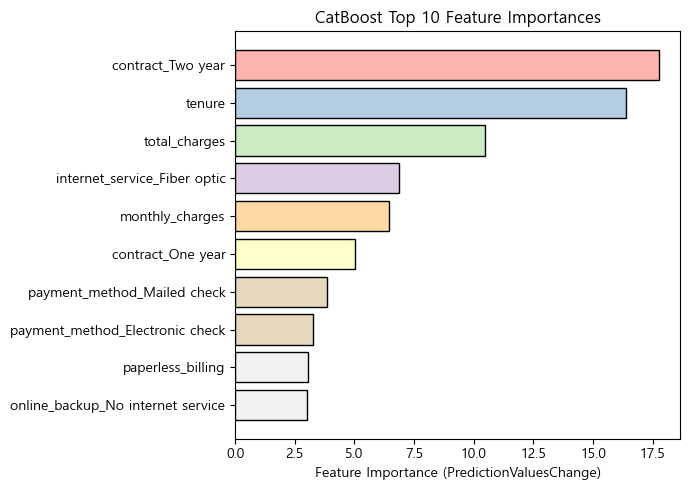

In [34]:
# 1) 전처리/모델 추출
pre = best_model.named_steps['pre']
clf = best_model.named_steps['clf']   # CatBoostClassifier (fitted)

# 2) 피처명(list) & 변환 데이터 준비
from catboost import Pool
import numpy as np
import matplotlib.pyplot as plt

feature_names = pre.get_feature_names_out().astype(str).tolist()
Xtr_trans = pre.transform(X_train)
if hasattr(Xtr_trans, "toarray"):    # sparse -> dense
    Xtr_trans = Xtr_trans.toarray()

# 3) 중요도 계산 (PredictionValuesChange)
pool = Pool(Xtr_trans, label=y_train, feature_names=feature_names)
importances = clf.get_feature_importance(pool, type='PredictionValuesChange')

# 4) Top-10 추출
k = 10
idx = np.argsort(importances)[::-1][:k]
feats = [feature_names[i] for i in idx]
imps  = importances[idx]

# 5) 시각화 (Pastel1 색상)
order = np.arange(k-1, -1, -1)  # barh는 아래가 마지막이므로 역순
cmap = plt.cm.get_cmap('Pastel1', k)
colors = cmap(range(k))

plt.figure(figsize=(7,5))
plt.barh([feats[i] for i in order], [imps[i] for i in order],
         color=colors[order], edgecolor='black')
plt.xlabel('Feature Importance (PredictionValuesChange)')
plt.title('CatBoost Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [35]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_model, X_valid, y_valid,
    scoring = 'average_precision', n_repeats = 10, random_state = SEED, n_jobs = -1
)
pi = (pd.Series(r.importances_mean, index=X_valid.columns)
        .sort_values(ascending=False)
        .head(10))
print("Permutation Importance (AP, Top10):")
print(pi)

# Permutation importance는 VALID에서 원본 컬럼을 섞어 AP가 얼마나 하락하는지로 중요도를 측정(일반화 관점).
# 전처리(OHE 등)가 파이프라인 내부에 있으므로, 한 원본 컬럼이 생성한 여러 더미 효과가 함께 반영.

Permutation Importance (AP, Top10):
tenure               0.097052
contract             0.092742
internet_service     0.050235
total_charges        0.021251
paperless_billing    0.016482
payment_method       0.013872
monthly_charges      0.012756
tech_support         0.009001
online_security      0.006035
device_protection    0.003447
dtype: float64


### tenure(가입기간), Monthly_charges 변수에 대한 이탈 확률 변화 체크
- partial dependence : 부분 의존성, 머신러닝 모델이 특정 피처의 값 변화에 따라 예측값이 어떻게 변하는지 확인하는 기법
- 장점 : 모델의 블랙박스 속에서도 특정 피처의 예측 영향 방향과 강도를 시각적으로 이해 가능. 

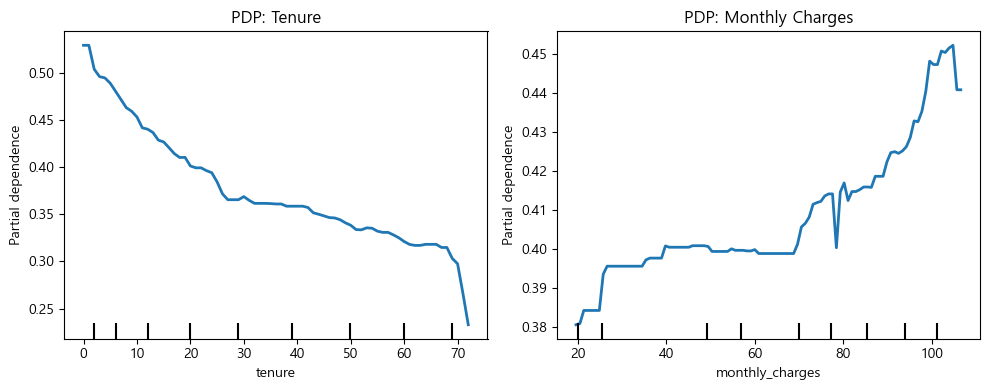

In [36]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

PartialDependenceDisplay.from_estimator(
    best_model, X_valid,
    features=['tenure'],
    target=1,
    kind='average',                # ← ICE 없애고 평균선만
    percentiles=(0.05, 0.95),
    grid_resolution=100,           # 선을 조금 더 부드럽게
    n_jobs=-1,
    ax=axes[0],
    line_kw={'linewidth': 2}       # 선 굵게(지원됨)
)
axes[0].set_title('PDP: Tenure')
axes[0].set_xlabel('Tenure (months)')
axes[0].set_ylabel('Predicted churn')

PartialDependenceDisplay.from_estimator(
    best_model, X_valid,
    features=['monthly_charges'],
    target=1,
    kind='average',
    percentiles=(0.05, 0.95),
    grid_resolution=100,
    n_jobs=-1,
    ax=axes[1],
    line_kw={'linewidth': 2}
)
axes[1].set_title('PDP: Monthly Charges')
axes[1].set_xlabel('Monthly Charges')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [84]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False 

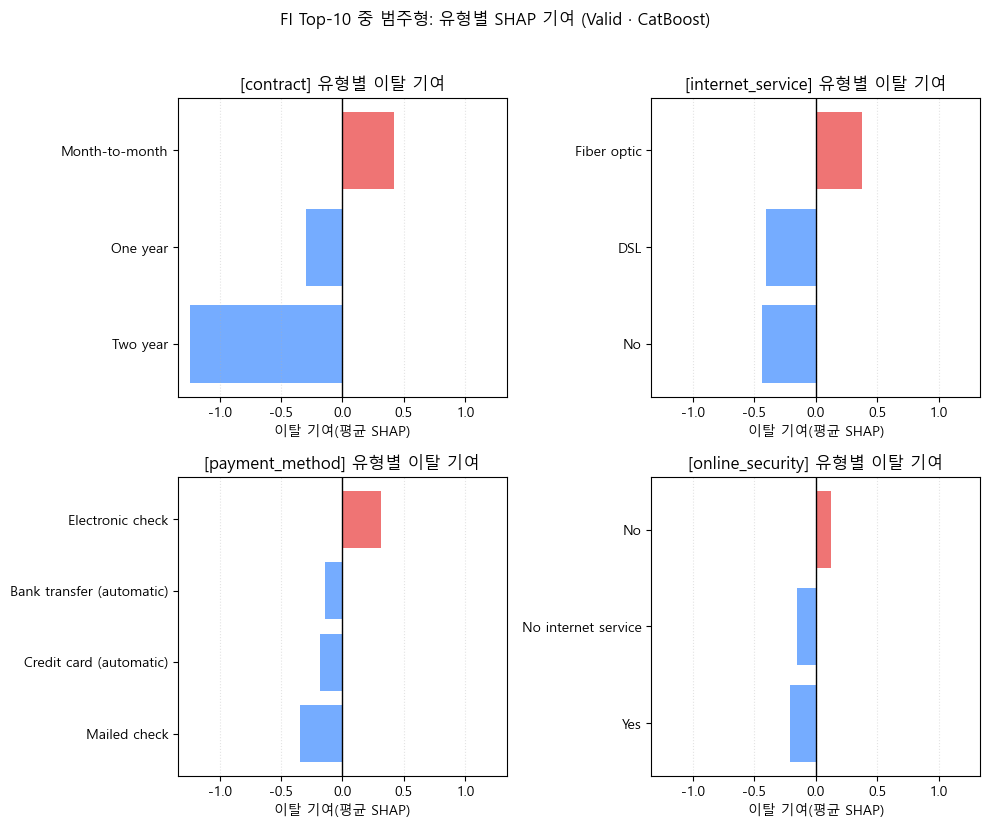

In [38]:
# (+): 해당 범주가 모델의 이탈 예측을 높이는 방향으로 기여한 경향
# (−): 해당 범주가 모델의 이탈 예측을 낮추는 방향으로 기여한 경향
# 평균 SHAP은 상호작용/상관의 영향을 받을 수 있으며 인과가 아님. 
# OHE 더미는 같은 원-특성의 범주들이므로, 원-특성 단위로 보기 위해 SHAP을 합산.

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from catboost import Pool

# ---------- 0) 준비 ----------
pre = best_model.named_steps["pre"]
clf = best_model.named_steps["clf"]

Xv_t = pre.transform(X_valid)
if hasattr(Xv_t, "toarray"): Xv_t = Xv_t.toarray()
feat_out = np.array([n.split("__", 1)[-1] for n in pre.get_feature_names_out()])  # 변환 후 피처명

# OHE 원-컬럼 식별(그룹핑 기준)
def infer_ohe_cols(pre, raw_cols):
    out = []
    try:
        for _, trans, cols_sel in pre.transformers_:
            steps = getattr(trans, "steps", None)
            tr = trans
            if steps:
                for _, est in steps:
                    if est.__class__.__name__ == "OneHotEncoder":
                        sel = cols_sel
                        if isinstance(sel, slice): sel = list(raw_cols[sel])
                        elif hasattr(sel, "__iter__"): sel = list(sel)
                        out.extend(sel)
            else:
                if tr.__class__.__name__ == "OneHotEncoder":
                    sel = cols_sel
                    if isinstance(sel, slice): sel = list(raw_cols[sel])
                    elif hasattr(sel, "__iter__"): sel = list(sel)
                    out.extend(sel)
    except Exception:
        pass
    return [c for c in out if c in X_train.columns]

ohe_cols = infer_ohe_cols(pre, X_train.columns)

# SHAP 값(마지막 열 base value 제거)
pool_v = Pool(pd.DataFrame(Xv_t, columns=feat_out, index=X_valid.index), label=y_valid)
S = clf.get_feature_importance(pool_v, type="ShapValues")[:, :-1]  # (n_samples, n_features)

# 모든 피처 → "원-특성"으로 그룹핑(OHE는 묶고, 나머지는 단독)
groups = {}
for f in feat_out:
    src = None
    for c in ohe_cols:
        if f.startswith(c + "_"):
            src = c; break
    groups.setdefault(src if src else f, []).append(f)

# ---------- 1) FI Top-10 산정(원-특성 단위 Mean|SHAP|) ----------
g_mag = {}
for g, members in groups.items():
    idxs = [np.where(feat_out == m)[0][0] for m in members]
    g_mag[g] = np.abs(S[:, idxs].sum(axis=1)).mean()
fi_top10 = [g for g, _ in sorted(g_mag.items(), key=lambda x: x[1], reverse=True)[:10]]

# Top-10 중 "범주형(OHE 원-특성)"만 추려 최대 4개(2×2)
cats_top = [g for g in fi_top10 if g in ohe_cols][:4]
if not cats_top:
    raise RuntimeError("FI Top-10 안에 범주형(OHE) 특성이 없습니다.")

# ---------- 2) 각 범주형의 '유형별 평균 SHAP' 데이터 준비 ----------
def get_level_mean_shap(feature, min_count=20):  # 표본이 적은 범주는 제외(min_count=20)
    members = groups[feature]
    idxs = [np.where(feat_out == m)[0][0] for m in members]
    shap_g = S[:, idxs].sum(axis=1)  # 가법성: 같은 원-특성 더미들의 SHAP 합

    lev = X_valid[feature].astype(str).fillna("(NA)")
    gp = (pd.DataFrame({"level": lev.values, "shap": shap_g})
          .groupby("level").agg(mean_shap=("shap","mean"), count=("shap","size")).reset_index())
    gp = gp[gp["count"] >= min_count]
    gp = gp.sort_values("mean_shap")  # 음수→양수
    return gp

data = {g: get_level_mean_shap(g, min_count=20) for g in cats_top}

# 공통 x축 범위(패널 간 비교를 위해 고정)
xmax = 0.0
for gp in data.values():
    if not gp.empty:
        xmax = max(xmax, np.abs(gp["mean_shap"]).max())
xpad = 0.08 * xmax
xlim = (-xmax - xpad, xmax + xpad)

# ---------- 3) 2×2 패널 그리기 ----------
soft_red  = "#EF6C6C"   # 위험(+) 쪽
soft_blue = "#6EA8FF"   # 보호(−) 쪽

def panel_fi_top_categorical(show_counts=False, title="FI Top-10 중 범주형: 유형별 SHAP 기여 (Valid · CatBoost)"):
    cols = 2
    rows = int(np.ceil(len(cats_top) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10.0, 4.2 * rows), squeeze=False)

    for ax, g in zip(axes.ravel(), cats_top):
        gp = data[g]
        if gp.empty:
            ax.axis("off"); ax.set_title(f"[{g}] (표본 부족)"); continue

        levels = gp["level"].tolist()
        vals = gp["mean_shap"].to_numpy()
        colors = np.where(vals >= 0, soft_red, soft_blue)

        y = np.arange(len(levels))
        ax.barh(y, vals, color=colors, alpha=0.95)
        ax.axvline(0, color="black", linewidth=1)
        ax.set_yticks(y)
        ax.set_yticklabels(levels)
        ax.grid(axis="x", linestyle=":", alpha=0.35)
        ax.set_xlim(*xlim)
        ax.set_xlabel("이탈 기여(평균 SHAP)")
        ax.set_title(f"[{g}] 유형별 이탈 기여")

        # (옵션) 값·표본수 주석 — 바 끝 '바깥쪽'에 붙여 겹침 방지
        if show_counts:
            for yi, (v, n) in enumerate(zip(vals, gp["count"])):
                ha = "left" if v >= 0 else "right"
                x_txt = v + (xpad * 0.6 if v >= 0 else -xpad * 0.6)
                ax.text(x_txt, yi, f"{v:+.3f} · n={int(n)}", va="center", ha=ha, fontsize=9, color="#444")

    # 남는 축 비우기
    for ax in axes.ravel()[len(cats_top):]:
        ax.axis("off")

    fig.suptitle(title, fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---------- 4) 실행 ----------
panel_fi_top_categorical(show_counts=False)


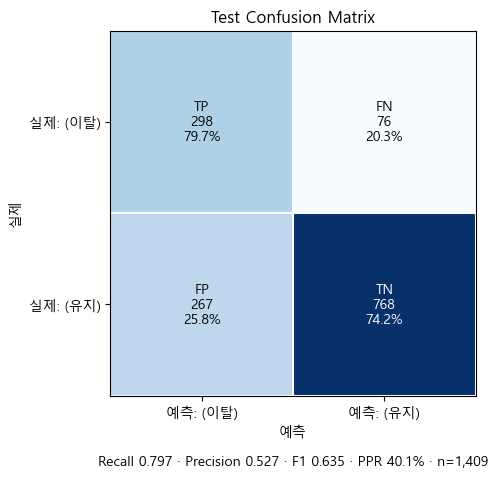

In [45]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confmat_at_threshold(
    y_true, y_prob, thr=0.531,
    title="Test Confusion Matrix"
):
    # 1) 예측 라벨
    y_pred = (y_prob >= thr).astype(int)
    n = len(y_true)

    # 2) 혼동행렬 (행=실제, 열=예측) — 실제 1이 첫 행이 되도록 고정
    cm_io = confusion_matrix(y_true, y_pred, labels=[1, 0])
    TP, FN = cm_io[0, 0], cm_io[0, 1]
    FP, TN = cm_io[1, 0], cm_io[1, 1]
    M = np.array([[TP, FN],
                  [FP, TN]], dtype=int)

    # 3) 지표
    recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    ppr = y_pred.mean()  # Predicted Positive Rate

    # 4) "행 기준 100%" 퍼센트 행렬 계산 (각 행 합계로 나눔)
    row_sums = M.sum(axis=1, keepdims=True)              # [[TP+FN],[FP+TN]]
    P = np.zeros_like(M, dtype=float)
    np.divide(M, row_sums, out=P, where=(row_sums != 0)) # 행 합계가 0인 경우는 0으로 유지

    # 5) 시각화
    fig, ax = plt.subplots(figsize=(5.6, 4.6))
    im = ax.imshow(M, cmap="Blues")

    # 축/라벨
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(["예측: (이탈)", "예측: (유지)"])
    ax.set_yticklabels(["실제: (이탈)", "실제: (유지)"])
    ax.set_xlabel("예측"); ax.set_ylabel("실제")
    ax.set_title(title)

    # 셀 주석: 라벨 + 개수 + (행 기준 %)  ← 여기서 %는 TP/(TP+FN) 등
    labels = np.array([["TP", "FN"], ["FP", "TN"]])
    for i in range(2):
        for j in range(2):
            v = M[i, j]
            pct_row = 100.0 * P[i, j]                       # 행기준 %
            ax.text(
                j, i,
                f"{labels[i,j]}\n{v:,}\n{pct_row:,.1f}%",
                ha="center", va="center", fontsize=10,
                color=("black" if M[i, j] < n * 0.25 else "white")
            )

    # 격자선
    ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=1.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    # 하단 요약: 셀 %는 "행 기준 100%"임을 명시
    fig.text(
        0.5, -0.18,
        f"Recall {recall:.3f} · Precision {precision:.3f} · F1 {f1:.3f} · "
        f"PPR {ppr*100:.1f}% · n={n:,}",
        transform=ax.transAxes, ha="center", va="center", fontsize=10
    )

    plt.tight_layout()
    plt.show()

thr_locked = 0.531
y_test_prob = best_model.predict_proba(X_test)[:, 1]
plot_confmat_at_threshold(y_test, y_test_prob, thr=thr_locked)


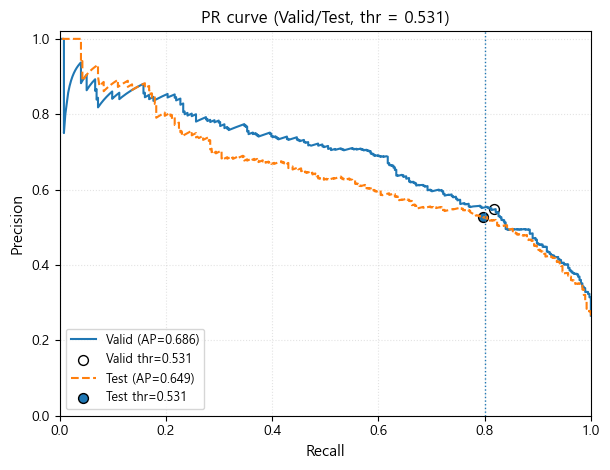

In [40]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def pr_curve_simple(y_valid, p_valid, y_test=None, p_test=None,
                    thr=0.531, target_recall=0.80,
                    title="PR curve (Valid/Test, τ locked)"):
    # --- Valid ---
    P1, R1, _ = precision_recall_curve(y_valid, p_valid)
    ap1 = average_precision_score(y_valid, p_valid)
    # locked-τ 지점(Valid)
    yv = (p_valid >= thr).astype(int)
    tp = ((y_valid==1) & (yv==1)).sum(); fp = ((y_valid==0) & (yv==1)).sum(); fn = ((y_valid==1) & (yv==0)).sum()
    prec_v = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec_v  = tp/(tp+fn) if (tp+fn)>0 else 0.0

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6.2, 4.8))
    ax.plot(R1, P1, label=f"Valid (AP={ap1:.3f})")
    ax.scatter([rec_v], [prec_v], s=50, facecolors="white", edgecolors="black",
               label=f"Valid thr={thr:.3f}")

    # --- Test(옵션) ---
    if (y_test is not None) and (p_test is not None):
        P2, R2, _ = precision_recall_curve(y_test, p_test)
        ap2 = average_precision_score(y_test, p_test)
        ax.plot(R2, P2, linestyle="--", label=f"Test (AP={ap2:.3f})")
        yt = (p_test >= thr).astype(int)
        tp = ((y_test==1) & (yt==1)).sum(); fp = ((y_test==0) & (yt==1)).sum(); fn = ((y_test==1) & (yt==0)).sum()
        prec_t = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec_t  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        ax.scatter([rec_t], [prec_t], s=50, edgecolors="black",
                   label=f"Test thr={thr:.3f}")

    # 정책선(Recall=0.80)
    ax.axvline(target_recall, linestyle=":", linewidth=1)

    ax.set_xlim(0, 1); ax.set_ylim(0, 1.02)
    ax.set_xlabel("Recall", fontsize = 11); ax.set_ylabel("Precision",  fontsize = 11)
    ax.set_title(title)
    ax.grid(True, linestyle=":", alpha=0.35)
    ax.legend(loc="lower left", fontsize=9)
    plt.tight_layout(); plt.show()

pr_curve_simple(y_valid, y_valid_prob, y_test, y_test_prob, thr=0.531, target_recall=0.80,
                title="PR curve (Valid/Test, thr = 0.531)")
